In [1]:

# %%
import os
import glob
import copy
import sys
import pickle 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np 


from rslds_visualization_utils import plot_states_and_neurons, plot_states_and_neurons_state_list
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

sys.path.append("/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/")
sys.path.append('/Users/bennetsakelaris/Documents/Obsidian Vault/Worms/wormcode/Code+Notes 09-24-24/collab/')

sys.path.append("/Users/friederikebuck/Downloads/worm notes/worm_code/")


from get_data.read_neuro_beh_data import get_exp_features, load_json
from get_data.process_neural_data import get_derivative_of_neural_activity, get_neural_activity_from_labels, get_neural_activity_and_labels
from beh_classification.behavior_features import get_behavior_features
from get_data.read_neuro_beh_data import get_exp_features, load_json

sys.path.append('/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/')
from beh_classification.process_midlines.midline_utils import save_as_csv, load_from_csv, convert_coordinates_to_angles
from rslds_motor_state_class_fncs import get_motor_state_start_end_is_rslds_start_end_specific

from load_data_fncs import load_all_data, get_exp_dates

from plotting_utils import plot_probabilities_hist, plot_hist_across_conditins_and_get_KS_stats
from categorize_reor_fncs import find_runs, make_masks, get_reor_mat, get_zero_crossing_indices, count_zero_crossing, get_date_to_state_bin, get_all_states_bin
from visualize_state_fncs import get_motor_state_start_end_is_rslds_start_end_specific_1, get_features_from_track_start_end_is, remove_nans, visualize_transition_matrix, get_rslds_pair_counts, plot_feature_hists_motor_states, get_pair_wise_avgs, plot_neural_activity_heatmap, plot_neural_activity
    

In [ ]:


T = 1599

motor_state_num_to_name = {
    0:"fwd", 
    1:"rev", 
    2:"turn", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}
rslds_state_num_to_name = {
    0:"fwd-like", 
    1:"rev-like", 
    2:"turn-like", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}

rslds_state_to_color = {
    0: "salmon", 
    1: "dodgerblue", 
    2: "green"
}


comp = "mac"
if comp == "hpc":
  project_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/keypt_moseq/projects/_1/"#sys.argv[1]+"_1"#/Volumes/FB1/moseq_project_dir/WholeBrainImagingAnalysis_1/"
  video_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
  video_clip_dir = "/ru-auth/local/home/fbuck/scratch/WholeBrainImaging/outputs_hpc/vid_clips/"

else: 
#   project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
# moseq_project_dir = ""
    project_dir = "/Volumes/FB1/moseq_project_dir_and_outputs/_1/"
    project_dir = "/Volumes/FB_data_ana/moseq_project_dir_and_outputs/_1/"
    video_dir = "/Users/friederikebuck/Desktop/MBL/project/outputs/" #"/Users/friederikebuck/Desktop/MBL/project/outputs/"  #when al subdirs with vids or keypoints are stored 
    video_clip_dir = "/Users/friederikebuck/Desktop/MBL/project/vid_clips/"
    save_dir = f"/Volumes/FB_data_ana/moseq_project_dir_and_outputs_figs/"

    # os.makedirs(save_dir, exist_ok=True)

json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
beh_data_dir_parent = "/Users/friederikebuck/Desktop/MBL/project/outputs/"
        
full_traces, full_neural_labels, full_beh_classification, full_beh_data = load_all_data()
velocity_og = np.array([full_beh_data[i]["velocity"][0:1599] for i in range(len(full_beh_data))])
acceleration_og = np.array([full_beh_data[i]["acceleration"][1:1600] for i in range(len(full_beh_data))])
head_curvature_og = np.array([full_beh_data[i]["head_angle"][0:1599] for i in range(len(full_beh_data))])
worm_curvature_og = np.array([full_beh_data[i]["worm_curvature"][0:1599] for i in range(len(full_beh_data))])
pumping_og = np.array([full_beh_data[i]["pumping"][0:1599] for i in range(len(full_beh_data))])
body_angle_mag_og = np.array([full_beh_data[i]["body_angle_mag"][0:1599] for i in range(len(full_beh_data))])
midlines_og =  np.array([full_beh_data[i]["midlines"][0:1599] for i in range(len(full_beh_data))])
body_angles_og =  np.array([full_beh_data[i]["body_angles"][0:1599] for i in range(len(full_beh_data))])

velocity = copy.deepcopy(velocity_og)
acceleration = copy.deepcopy(acceleration_og)
head_curvature = copy.deepcopy(head_curvature_og)
worm_curvature = copy.deepcopy(worm_curvature_og)
pumping = copy.deepcopy(pumping_og)
body_angle_mag =copy.deepcopy(body_angle_mag_og)
midlines =copy.deepcopy( midlines_og)
body_angles = copy.deepcopy(body_angles_og)




pdf_save_dir = "/Users/friederikebuck/Downloads/worm notes/rslds_all_dates/"
os.makedirs(pdf_save_dir, exist_ok=True)
directories = glob.glob(json_dir+"*.json") #get filename/paths of all the json files
exp_dates = [directory.split("/")[-1].split(".")[0] for directory in directories] #extract the exp_dates
# exp_date_to_jpeg_dir = {exp_date: exp_to_jpeg_dir(exp_date) for exp_date in exp_dates} ###for not wusing 10sx eesmapled..s hould use confocal..? go from rslds to 20 

   
kappas = np.logspace(3,7,5)
kappas = [kappas[0]]
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 200
time_bin = 10
prefix = 'my_kappa_scan'
# for kappa in kappas: #kappas[:2]
kappa = kappas[0]
print(f"Fitting model with kappa={kappa}")
model_name = f'{prefix}-{kappa}'
# fig_save_dir = os.path.join(save_dir, model_name)

np.random.seed(0)

foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
items = np.array(os.listdir(foldername))
folders = np.array(["." not in directory for directory in items], dtype=bool)
folders = items[folders]

folder = folders[0]


with open(foldername+"/Y.npy", 'rb') as handle:  
    Y = pickle.load(handle)


with open(foldername+folder+"/saved_data/prior.npy", 'rb') as handle:
    global_worm = pickle.load(handle)
    global_worm.D = int(global_worm.D)

with open(foldername+folder+"/saved_data/prior_q.npy", 'rb') as handle:
    q = pickle.load(handle)
    

slds = global_worm

neural_labels = np.load(foldername+"/neurons.npy", allow_pickle=True)


print(np.array(Y).shape)

print(len(neural_labels))



slds = global_worm
# get estimated latents, states
q_x = q.mean_continuous_states
q_z = [slds.most_likely_states(q_x[w], Y[w]) for w in range(len(q_x))]

z = [beh_classification["is_fwd"][0:1599]+ 2*beh_classification["is_rev"][0:1599]+ 4*beh_classification["is_pause"][0:1599]+3*beh_classification["is_turn"][0:1599]-1 for beh_classification in full_beh_classification]
q_z= np.array(q_z)
print(q_z.shape)
z = np.array(z)
print(z.shape)

Worm 0, date: 2022-06-14-01
Worm 1, date: 2023-01-23-08
Worm 2, date: 2022-06-28-07
Worm 3, date: 2022-07-15-12
Worm 4, date: 2023-01-19-01
Worm 5, date: 2022-08-02-01
Worm 6, date: 2022-06-14-07
Worm 7, date: 2022-06-28-01
Worm 8, date: 2023-01-23-15
Worm 9, date: 2022-07-26-01
Worm 10, date: 2023-01-19-15
Worm 11, date: 2023-03-07-01
Worm 12, date: 2022-06-14-13
Worm 13, date: 2023-01-23-21
Worm 14, date: 2023-01-19-22
Worm 15, date: 2023-01-23-01
Worm 16, date: 2023-01-17-01
Worm 17, date: 2022-07-20-01
Worm 18, date: 2023-01-09-28
Worm 19, date: 2023-01-19-08
Worm 20, date: 2022-07-15-06


/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


Fitting model with kappa=1000.0
(21, 1599, 138)
138
(21, 1599)
(21, 1599)


In [33]:

motor_state_num_to_name = {
    0:"fwd", 
    1:"rev", 
    2:"turn", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}
rslds_state_num_to_name = {
    0:"fwd-like", 
    1:"rev-like", 
    2:"turn-like", 
    3:"pure rev", 
    4:"rev of rev turn", 
    5:"turn of rev turn", 
    6:"pure turn"
}

feature_to_dict = {
    "n body swings":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda body_angle_over_event: len(get_zero_crossing_indices(body_angle_over_event)), 
         "ylim": [0, 0.5],
          "ylabel": "P(n body swings)", 
        #   "feature_mat": np.concatenate([get_body_angle_mag_from_midline(midline)[1][:, 20][:, None] for date, midline in exp_date_to_midlines.items()], axis = 1), 
        "feature_mat": body_angles[:,:, 20]
    },
        
    "duration (s)": {
        "exp_date_to_feature": "", 
        "bins": np.linspace(0, 45, 25), 
         "feature_fnc": lambda x: np.nanmax(x), 
         "ylim": [0, 0.5],
          "ylabel": "P(duration)", 
          "feature_mat": "", 
        
    },
        
    "curviness (radians)":
        {
            # "exp_date_to_feature": exp_date_to_body_angle_mag, 
         "bins": np.linspace(0,16, 25), 
         "feature_fnc": lambda x: np.nanmax(x), 
         "ylim": [0, 0.2], 
          "ylabel": "P(curviness)", 
        #   "feature_mat": np.concatenate([exp_date_to_body_angle_mag[date][:, None] for date in exp_dates], axis = 1)
        "feature_mat": body_angle_mag
        } , 
    # "velocity (mm/s)": (exp_date_to_velocity,   np.linspace(0,0.35, 50),  lambda x: np.max(np.abs(x))), 
    "speed (um/s)": 
        {
            # "exp_date_to_feature": exp_date_to_velocity, 
         "bins":  np.linspace(0,350, 25),
         "feature_fnc": lambda x:np.nanmax(np.abs(x)), 
         "ylim": [0, 0.24], 
         "ylabel": "P(max speed)", 
        #  "feature_mat": np.concatenate([exp_date_to_velocity[date][:, None] for date in exp_dates], axis = 1)
        "feature_mat": velocity
        } , 
    # # "head angle": (exp_date_to_head_angle,  50,  lambda x: np.mean(x)),#np.arange(0, 6, 0.01)), , 
    "acceleration (um/s^2)": 
        {
            # "exp_date_to_feature": exp_date_to_acceleration, 
         "bins":  np.linspace(0,0.015, 25),
         "feature_fnc":  lambda x: np.nanmax(np.abs(x)), 
         "ylim": [0, 0.14] ,
          "ylabel": "P(max acceleration)", 
        #   "feature_mat": np.concatenate([exp_date_to_acceleration[date][:, None] for date in exp_dates], axis = 1). 
         "feature_mat": acceleration
        } , 
    
}


(array([5.000e+00, 8.100e+01, 1.404e+03, 6.142e+03, 5.245e+03, 9.311e+03,
        9.424e+03, 1.842e+03, 1.190e+02, 6.000e+00]),
 array([-250.58633306, -200.87770166, -151.16907027, -101.46043887,
         -51.75180748,   -2.04317609,   47.66545531,   97.3740867 ,
         147.0827181 ,  196.79134949,  246.49998089]),
 <BarContainer object of 10 artists>)

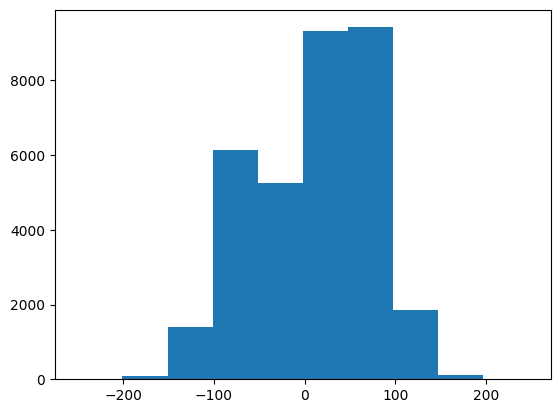

feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)


/var/folders/8z/xy4sl8b90qnc_x9p_4psrnmh0000gn/T/ipykernel_21476/2784010955.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)


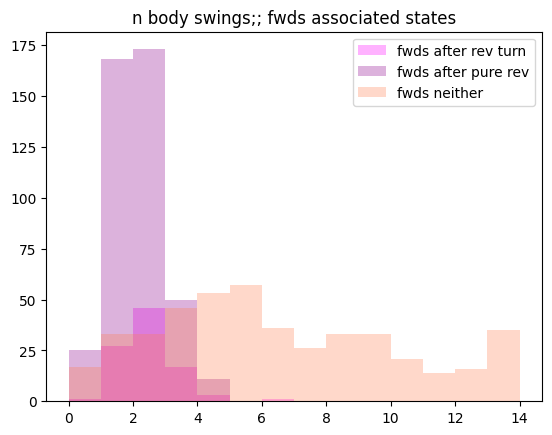

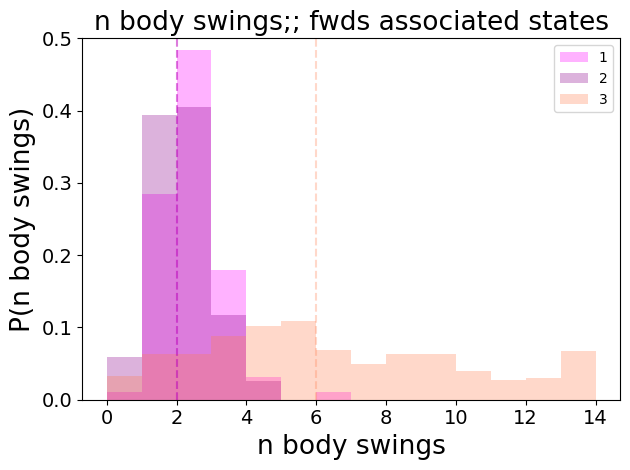

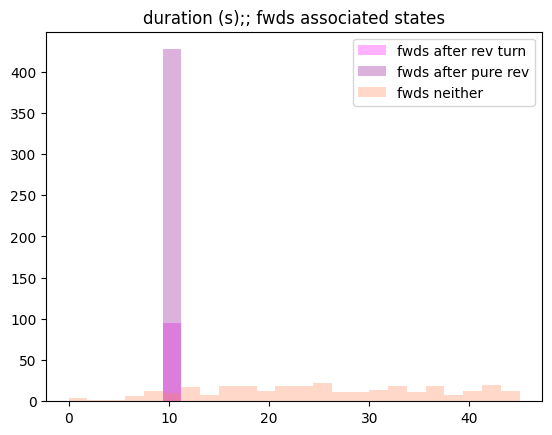

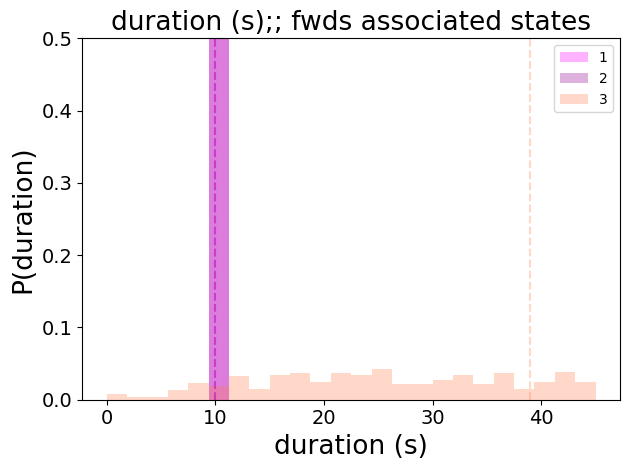

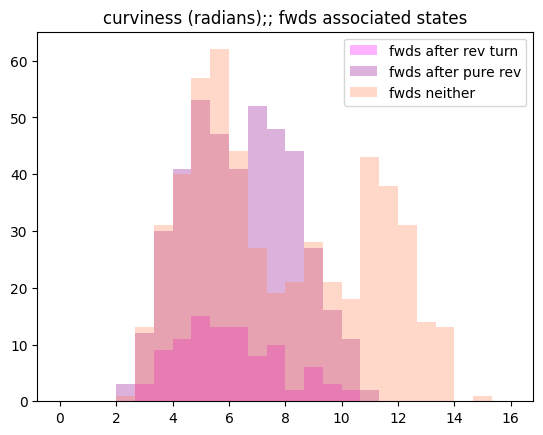

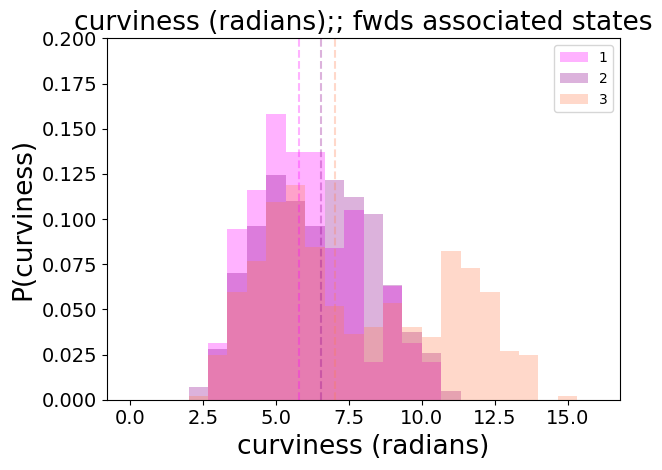

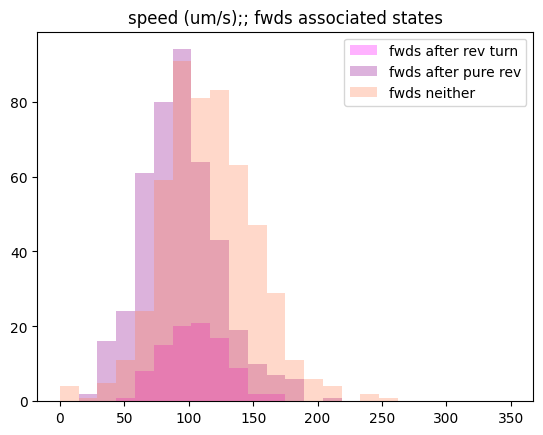

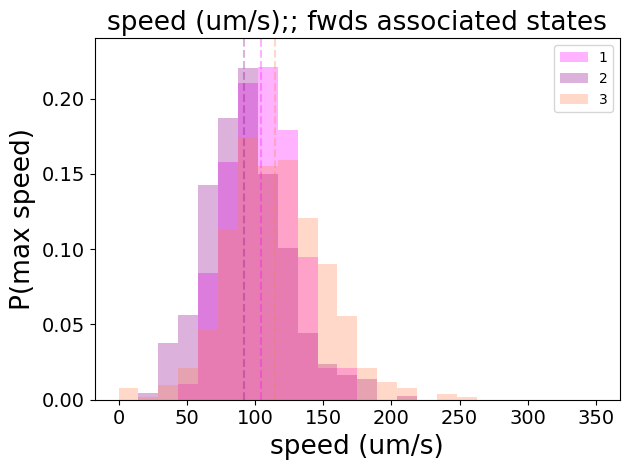

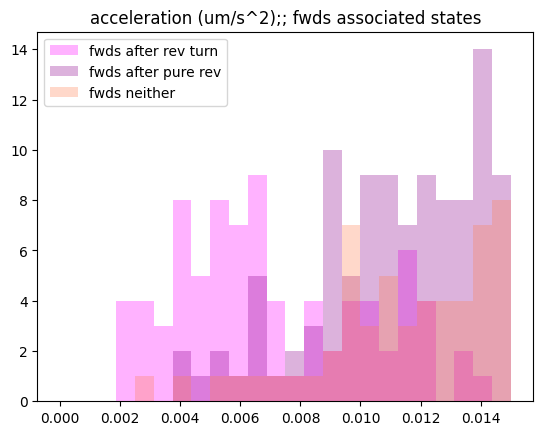

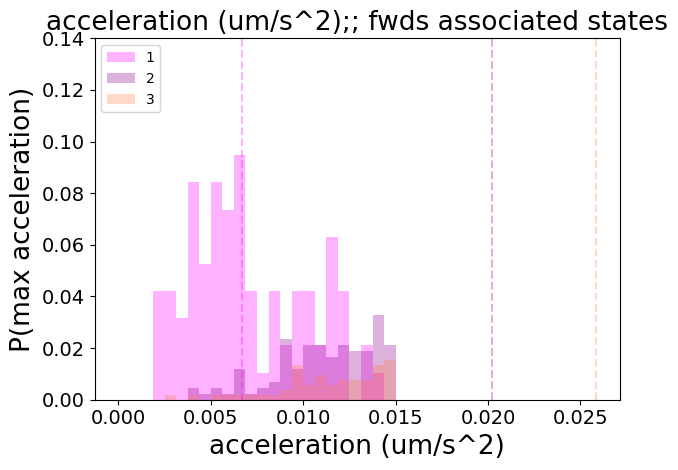

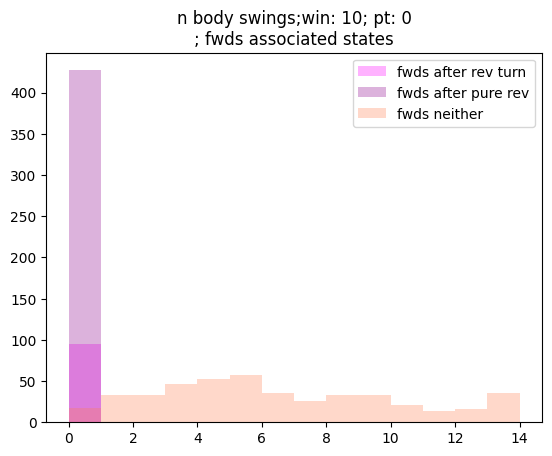

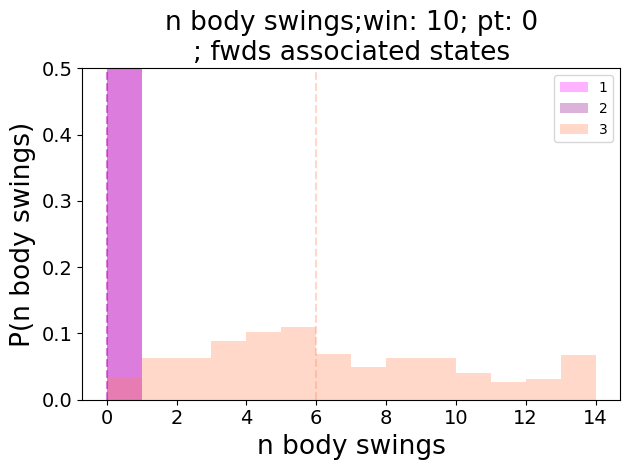

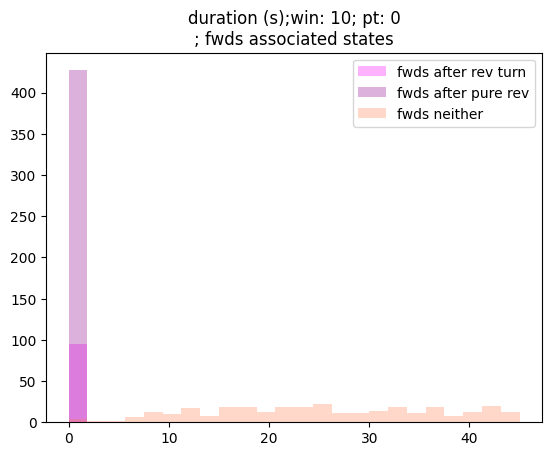

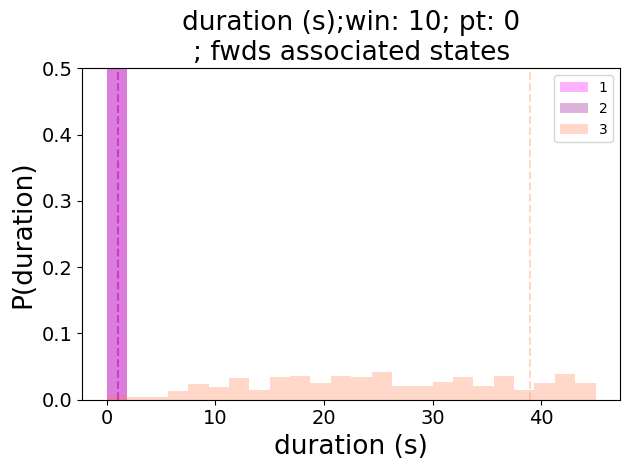

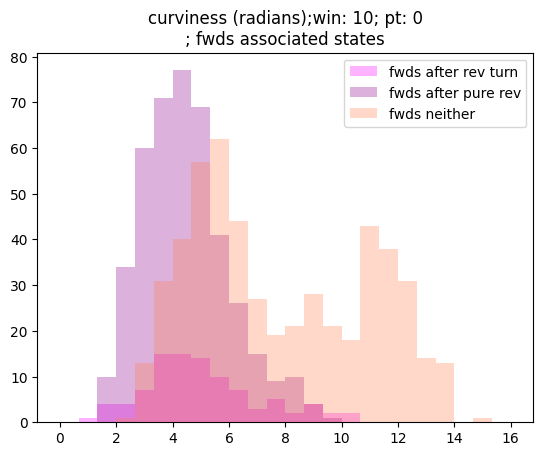

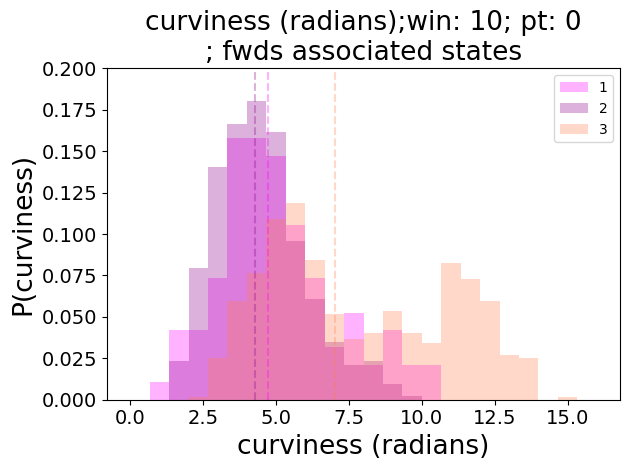

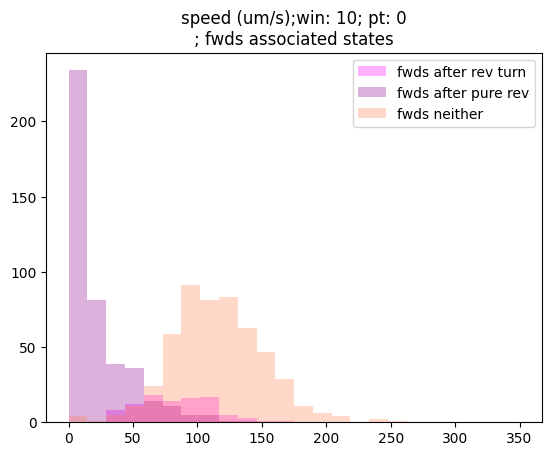

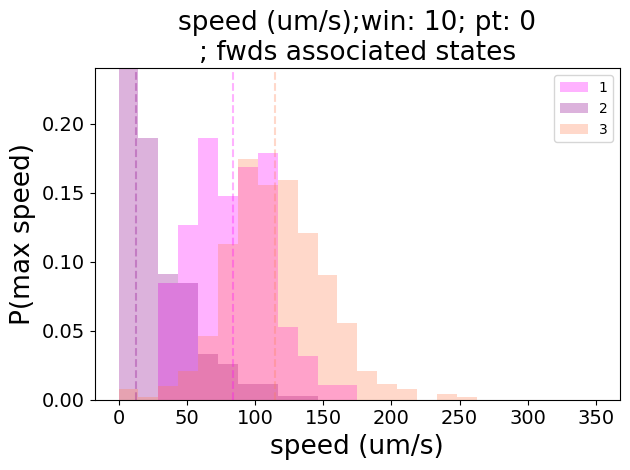

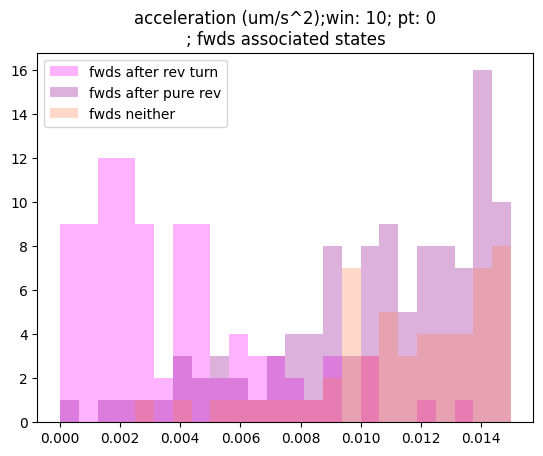

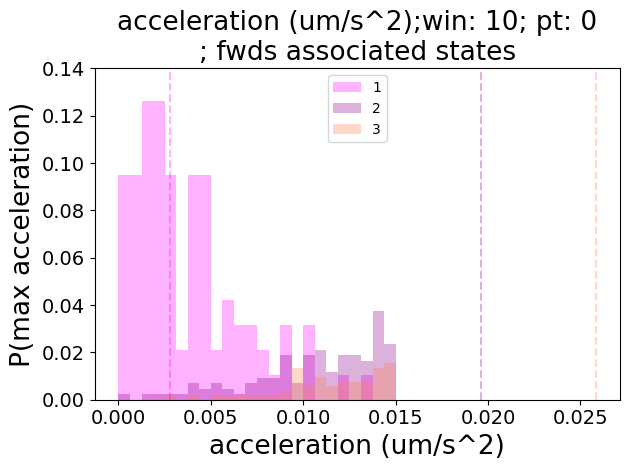

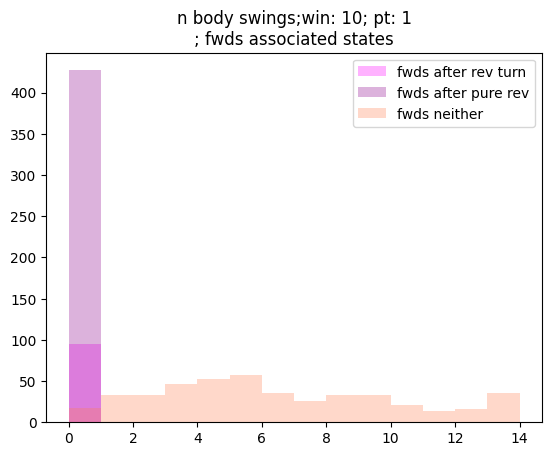

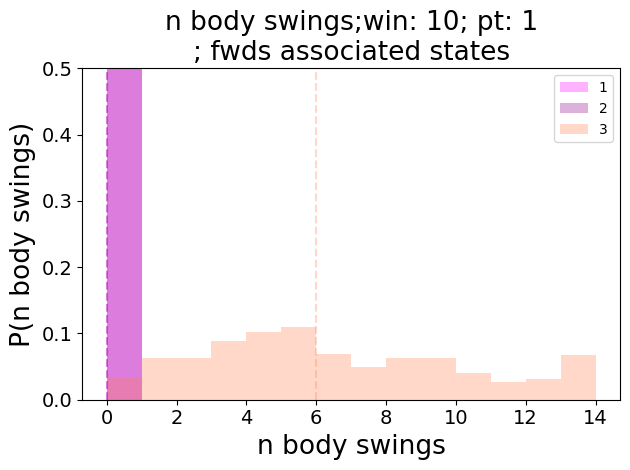

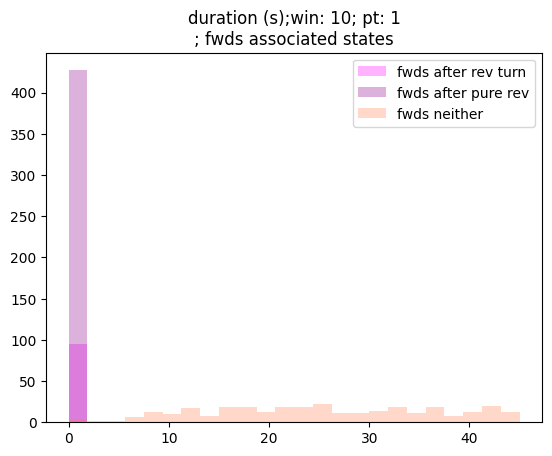

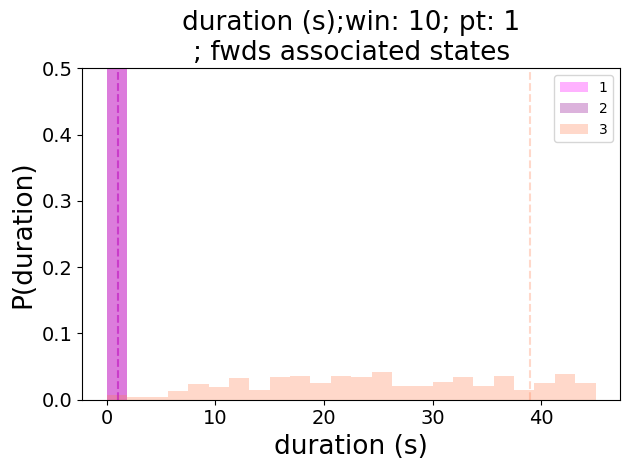

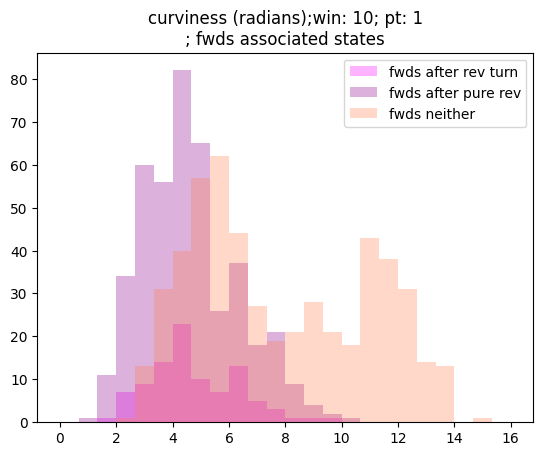

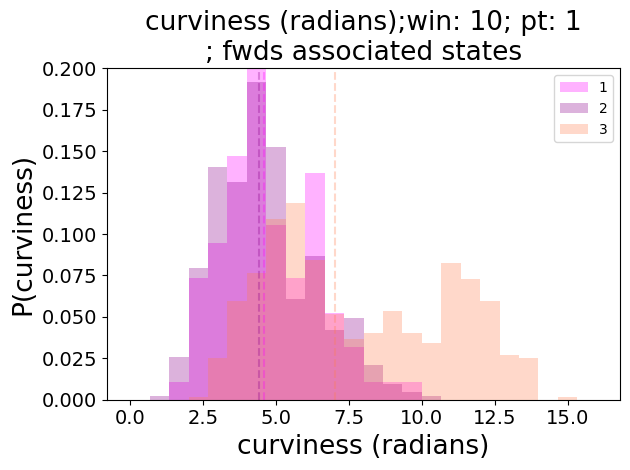

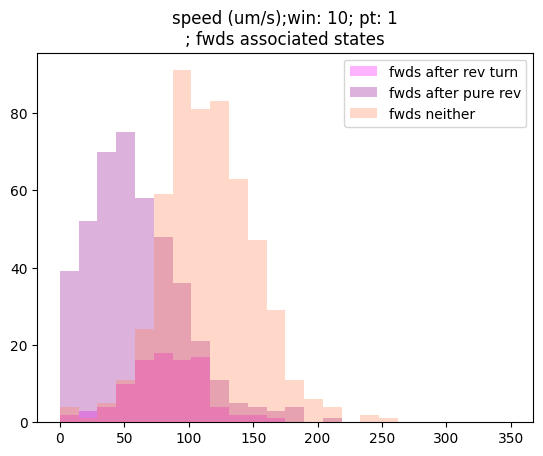

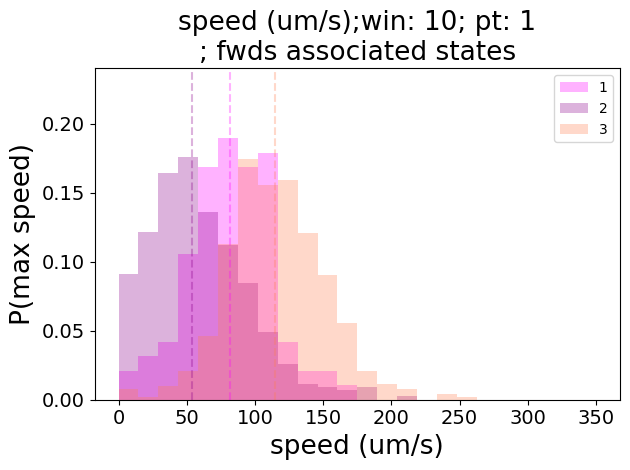

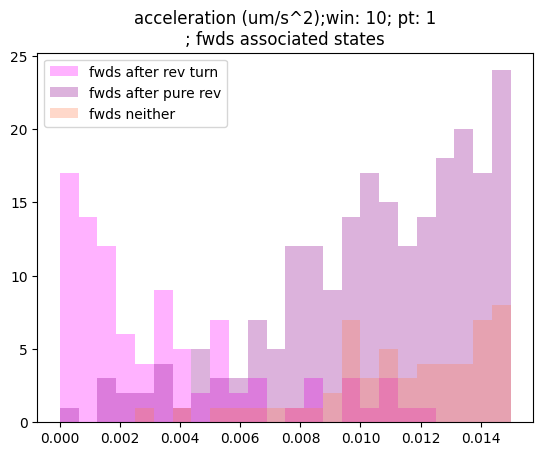

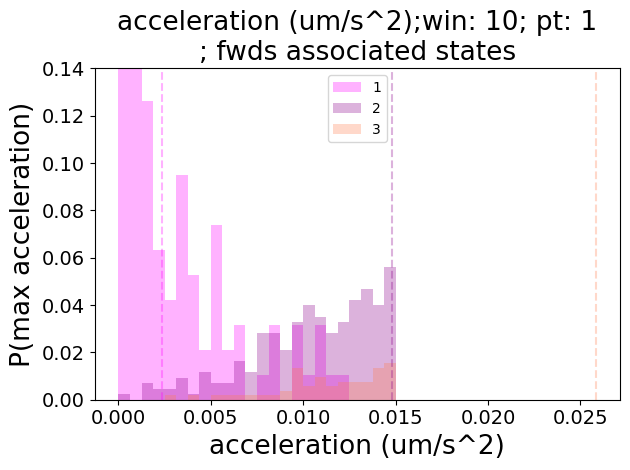

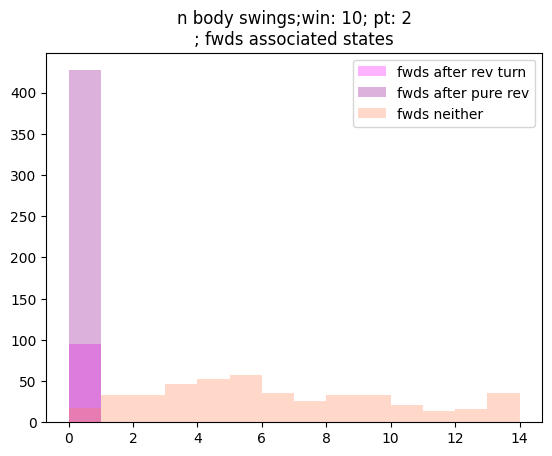

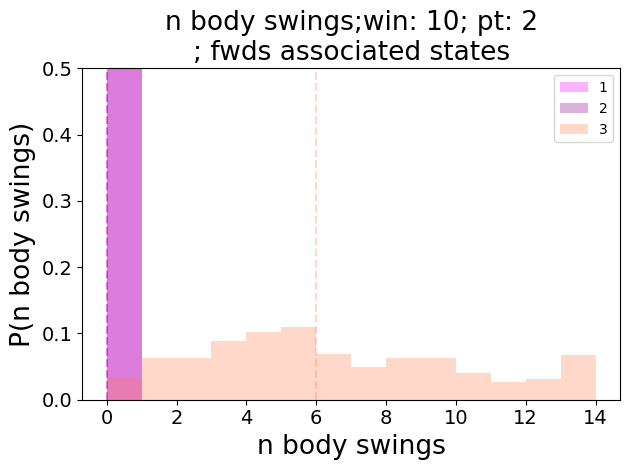

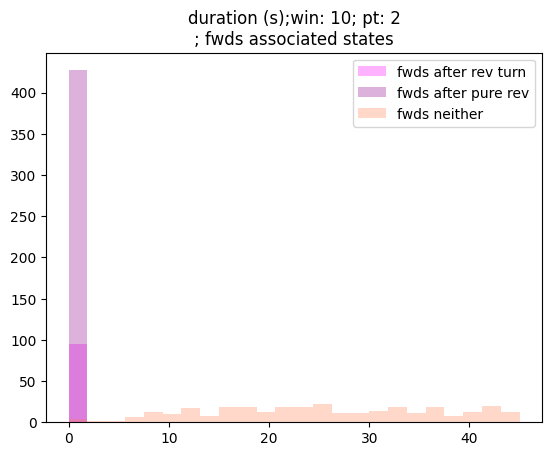

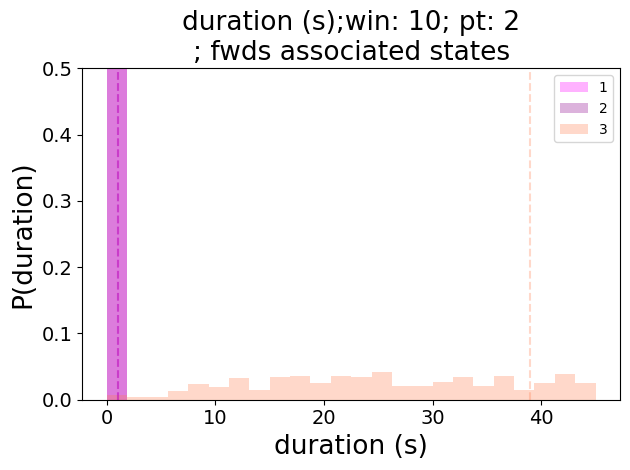

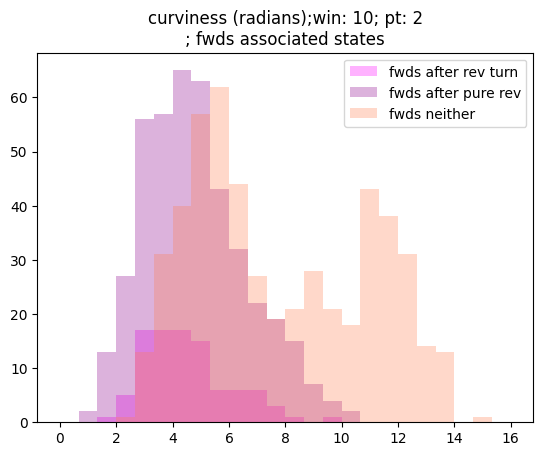

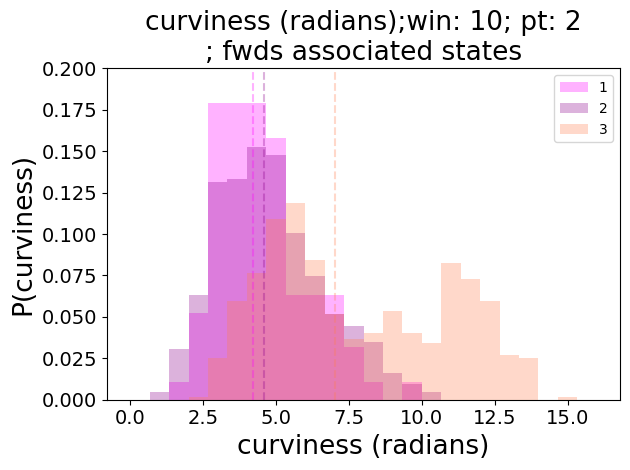

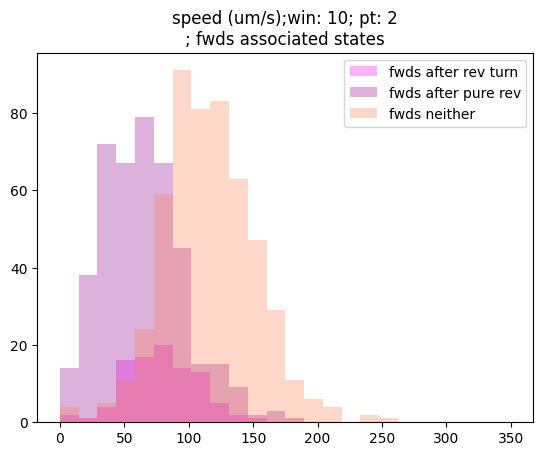

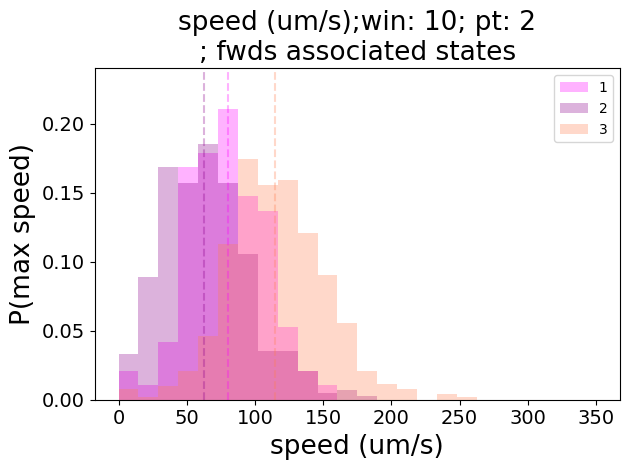

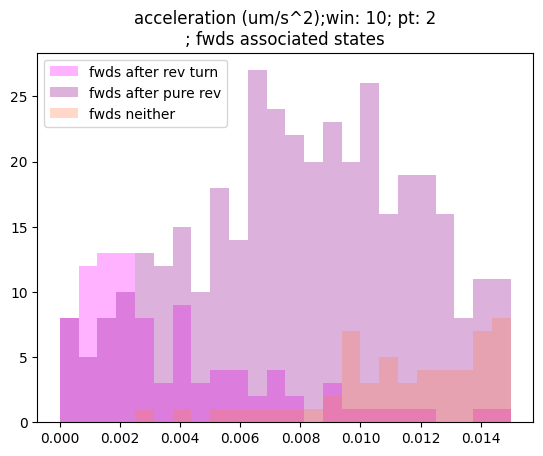

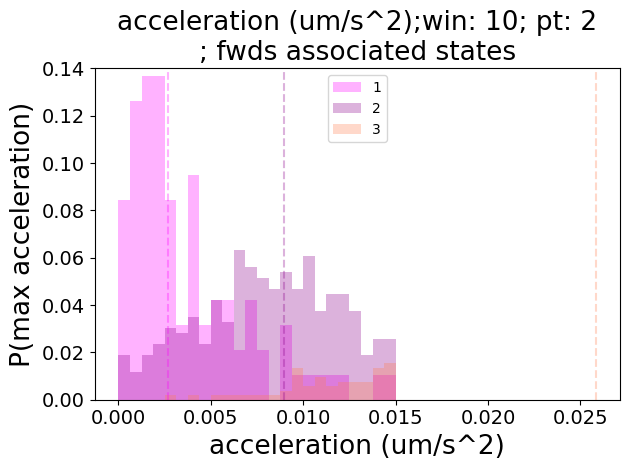

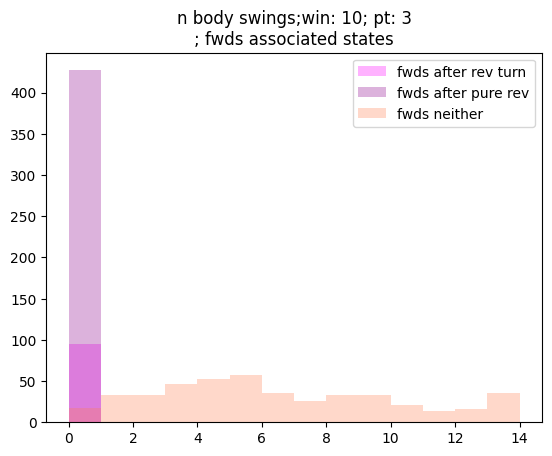

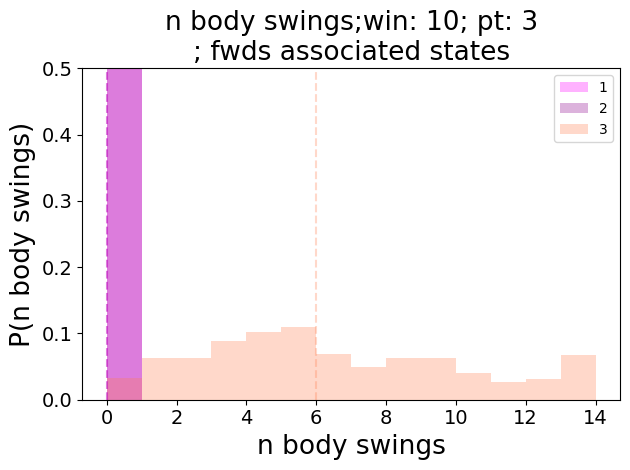

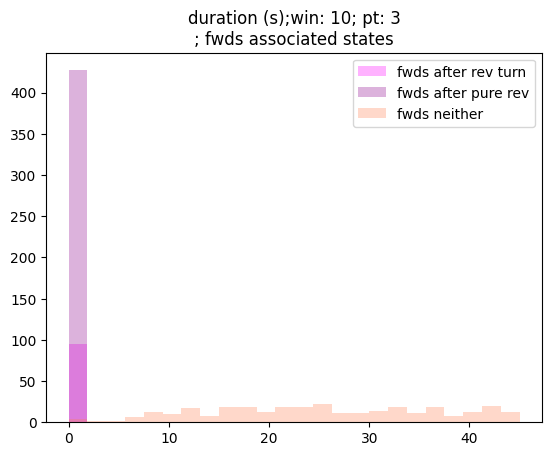

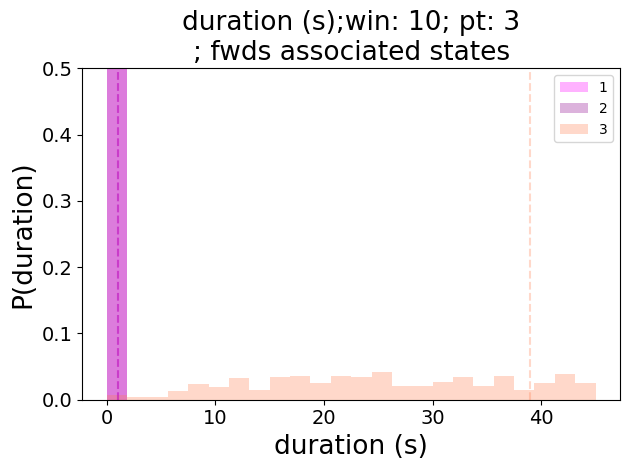

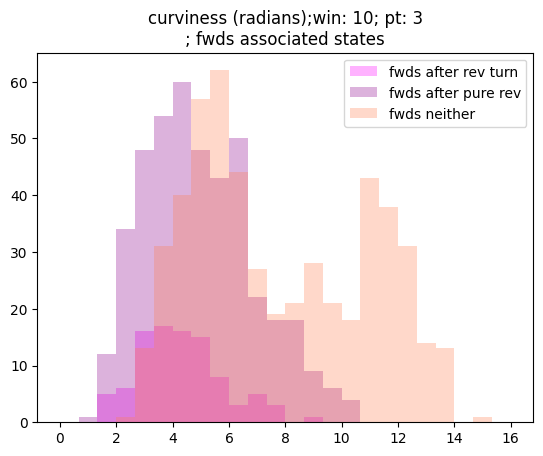

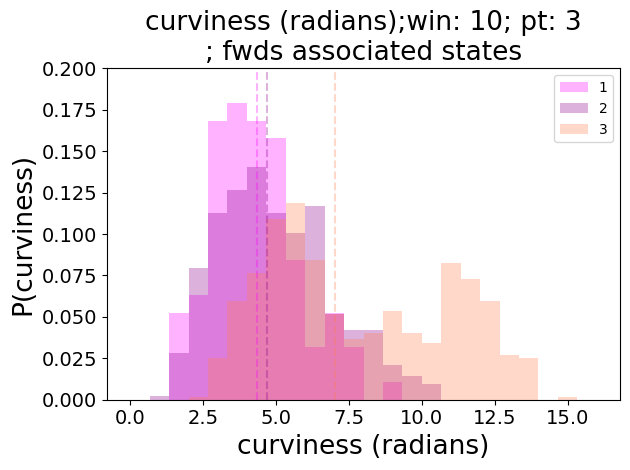

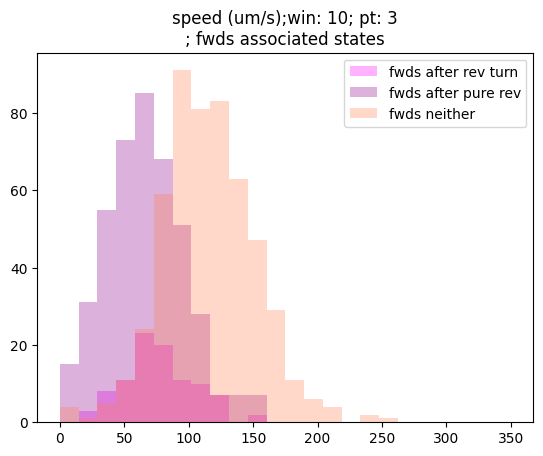

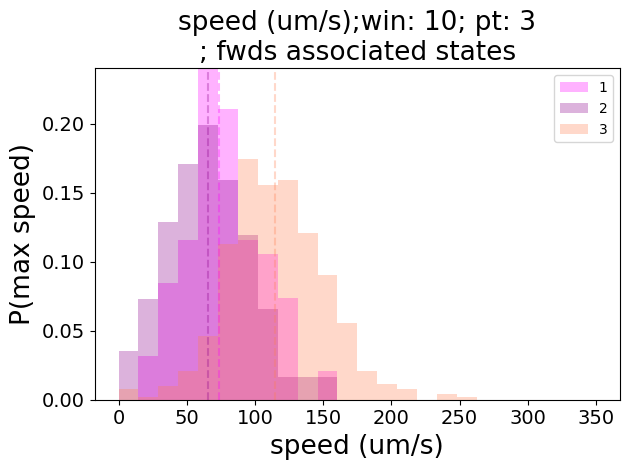

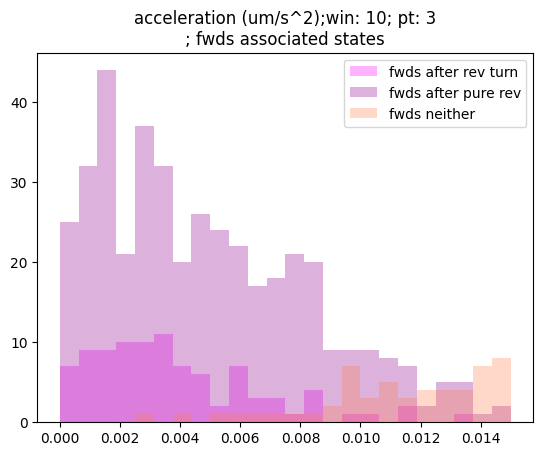

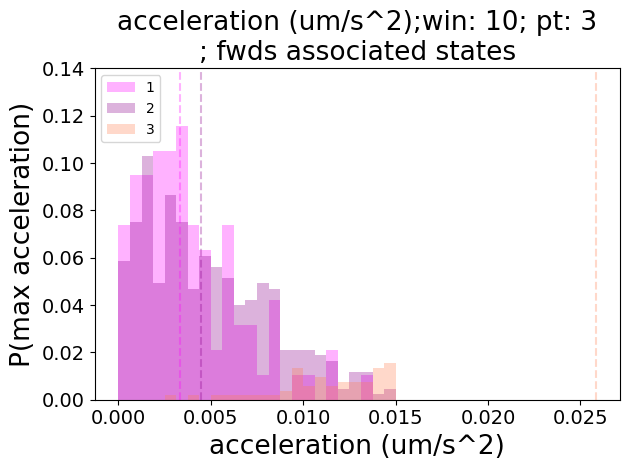

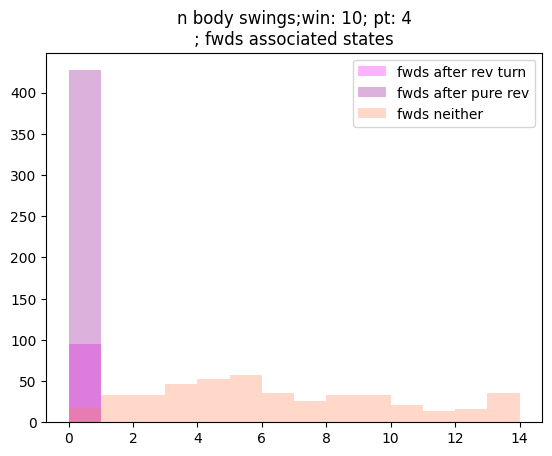

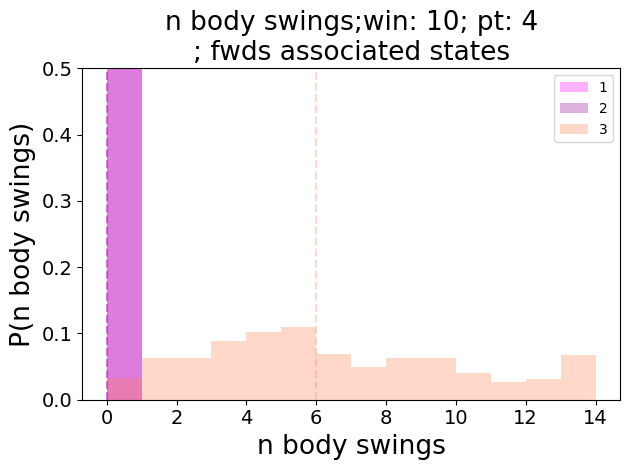

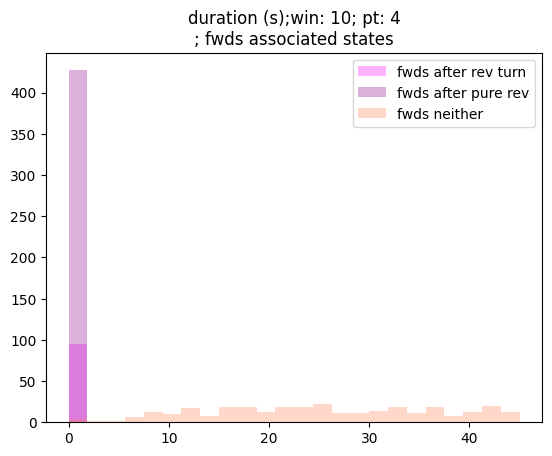

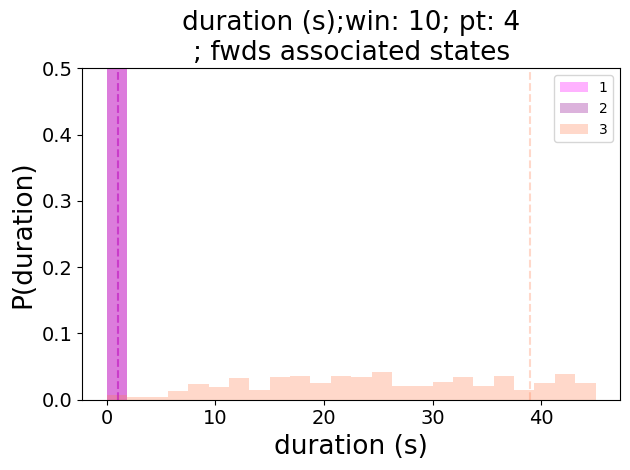

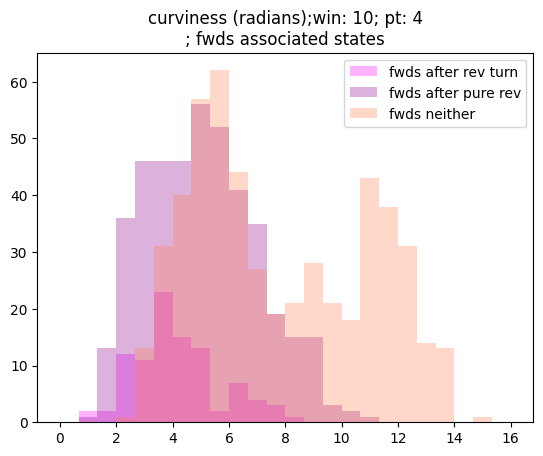

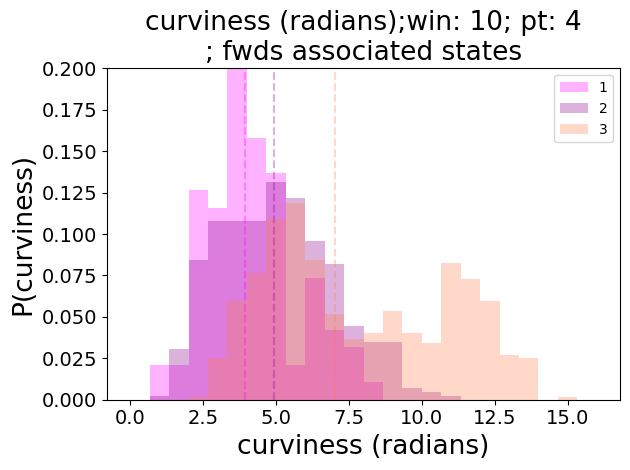

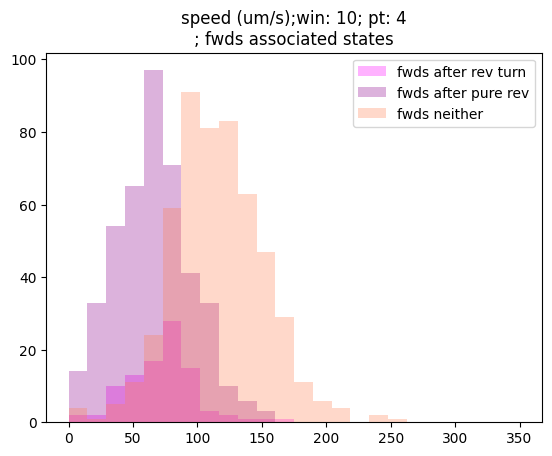

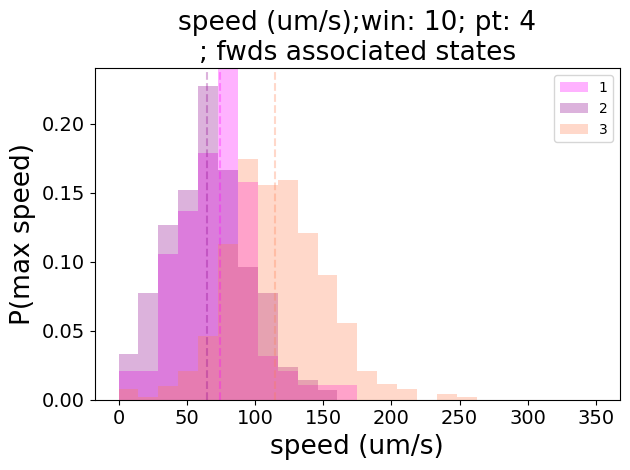

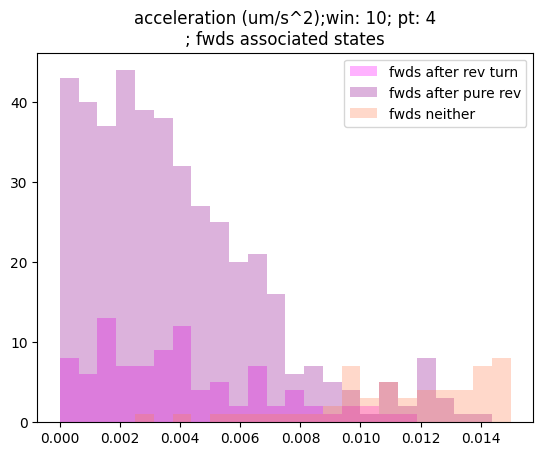

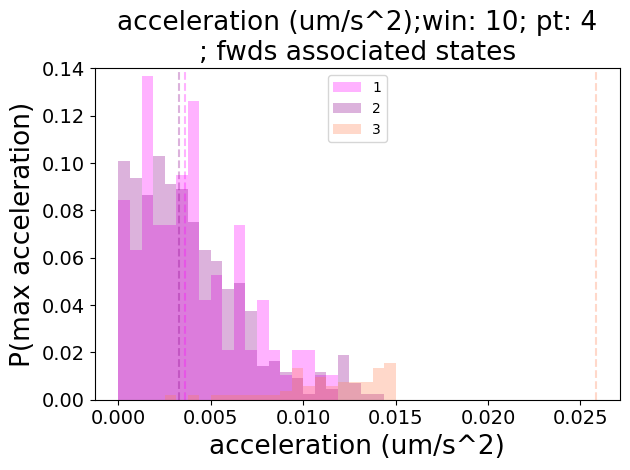

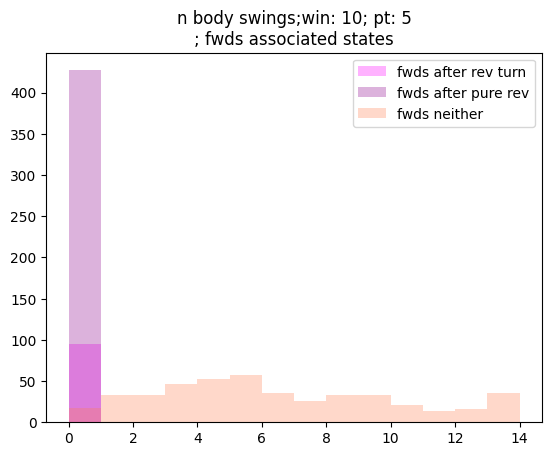

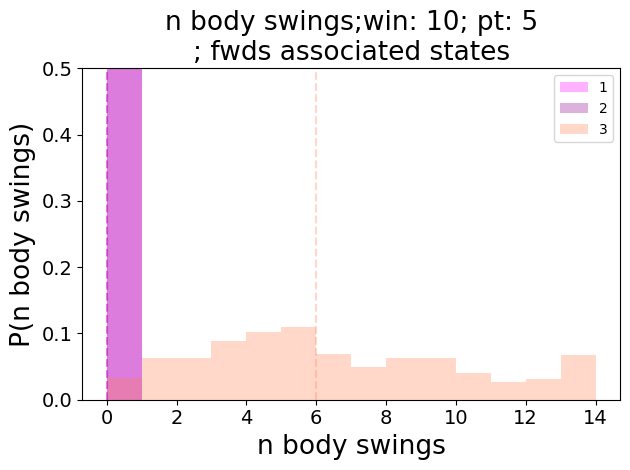

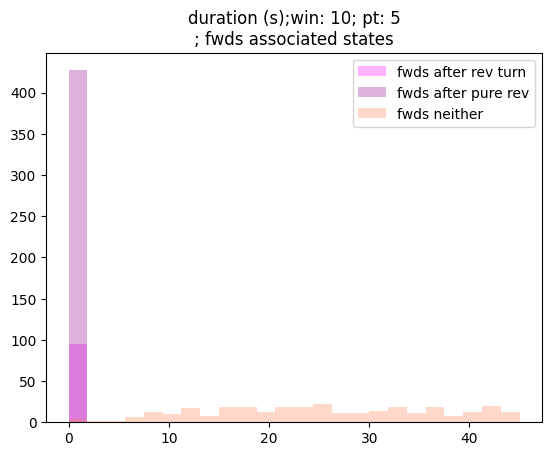

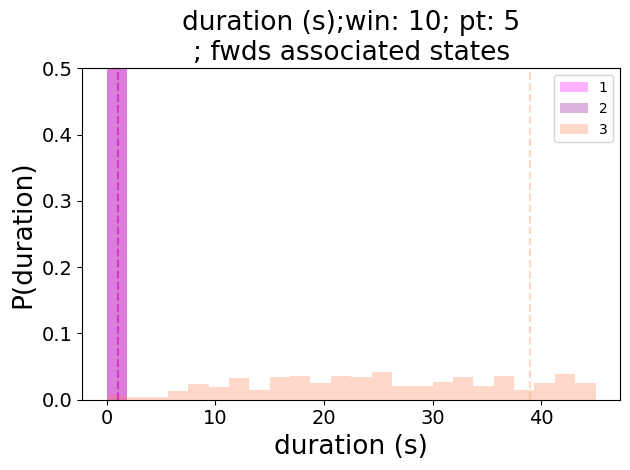

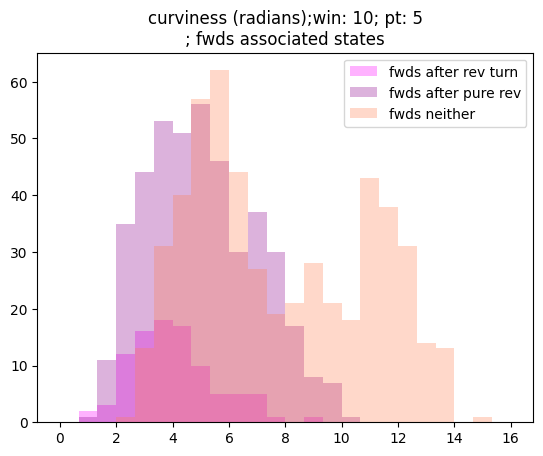

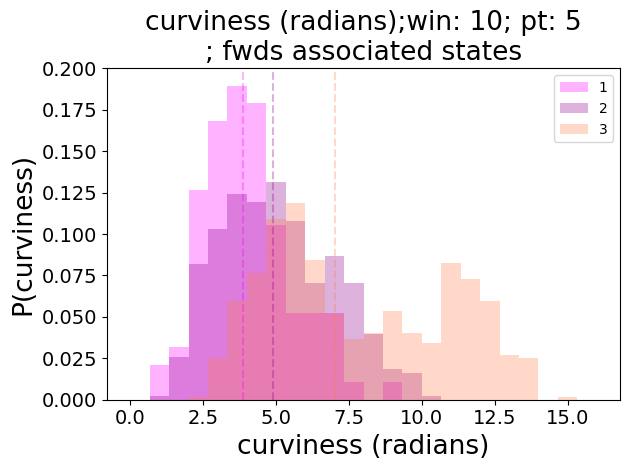

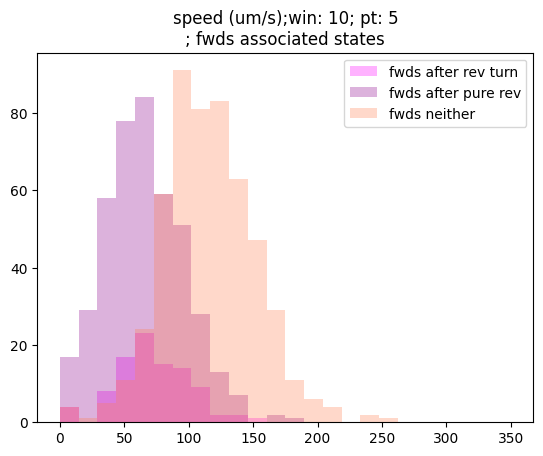

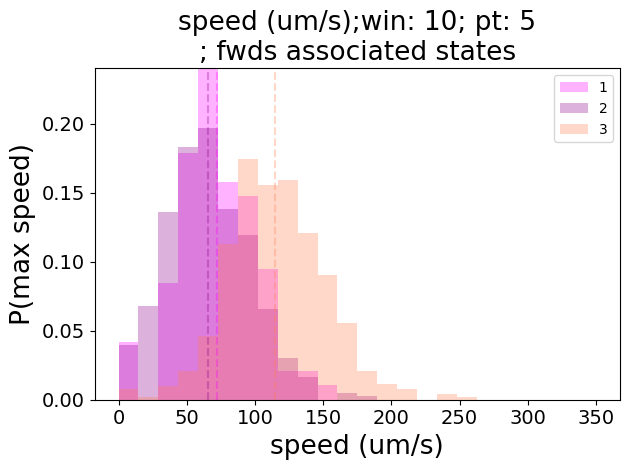

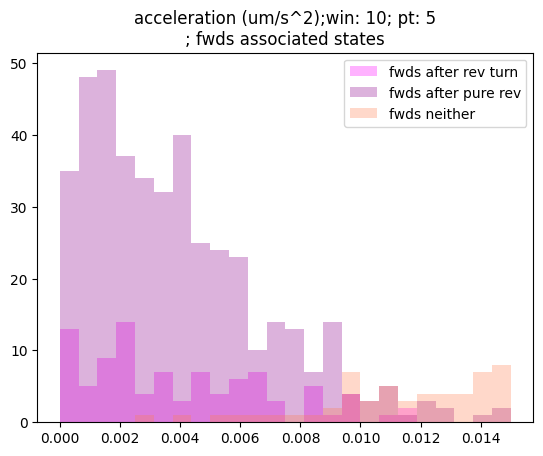

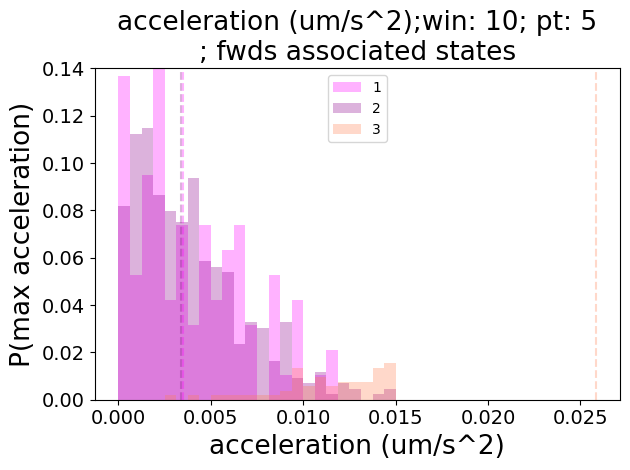

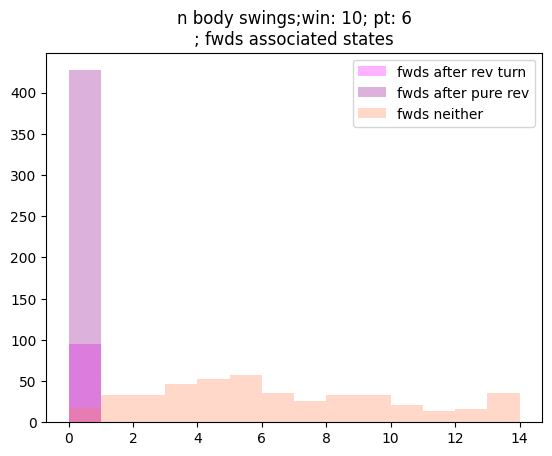

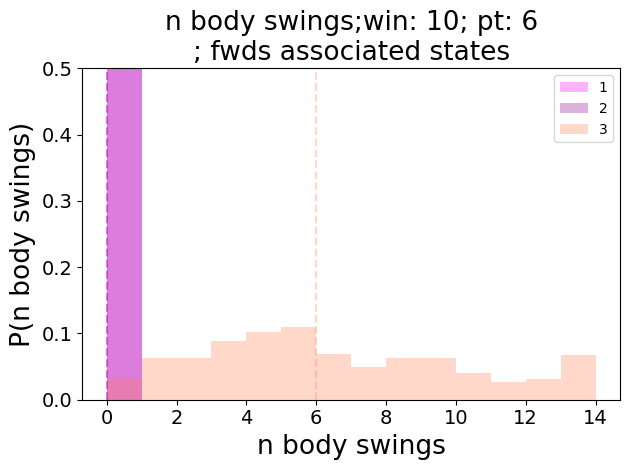

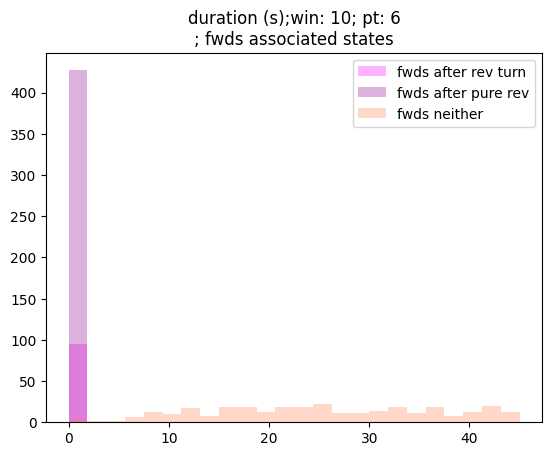

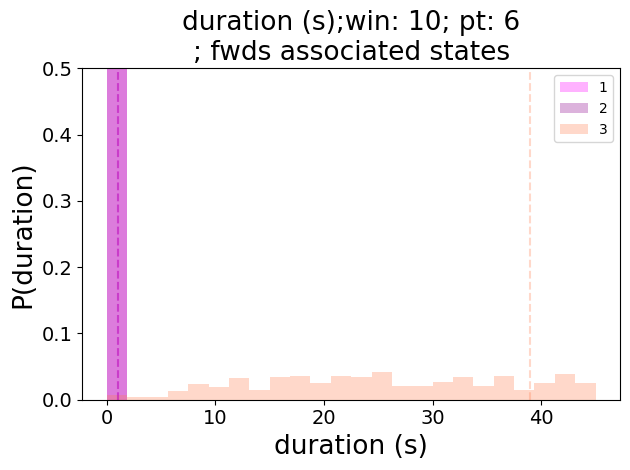

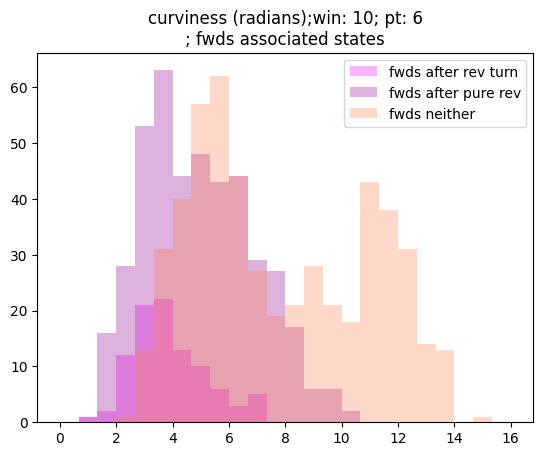

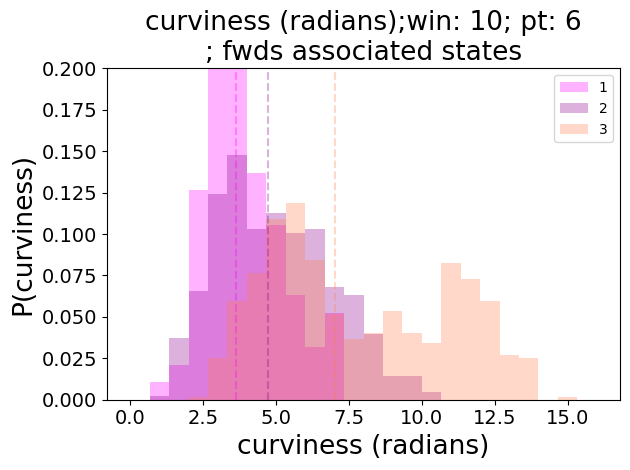

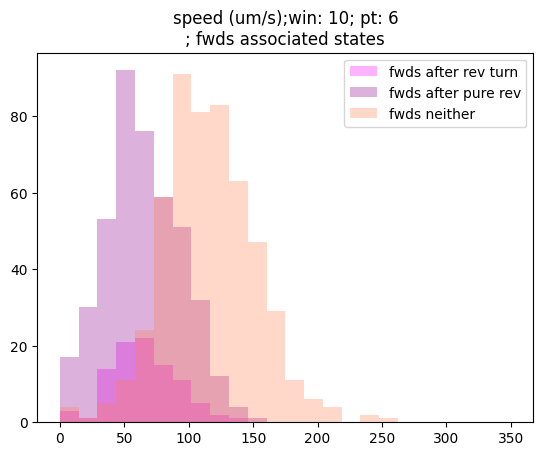

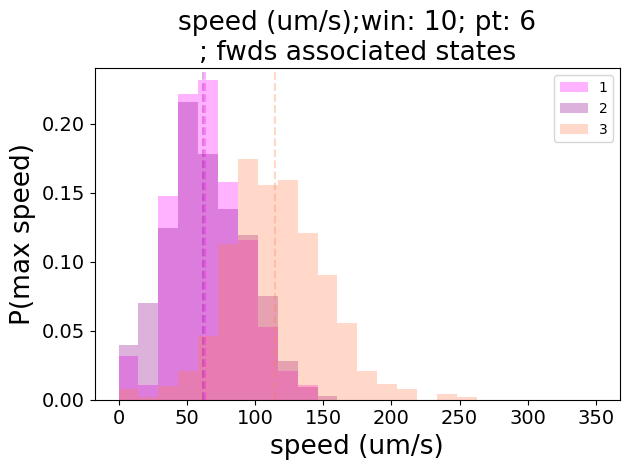

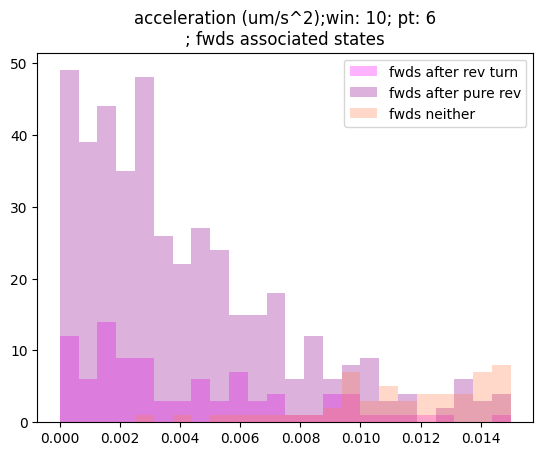

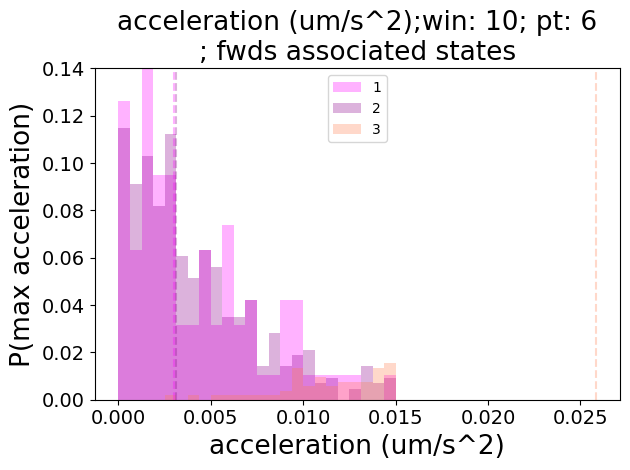

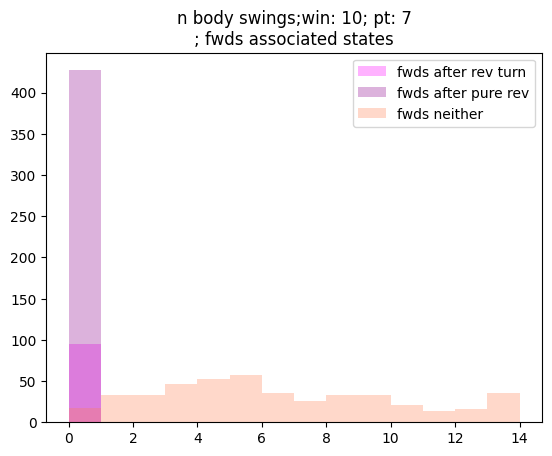

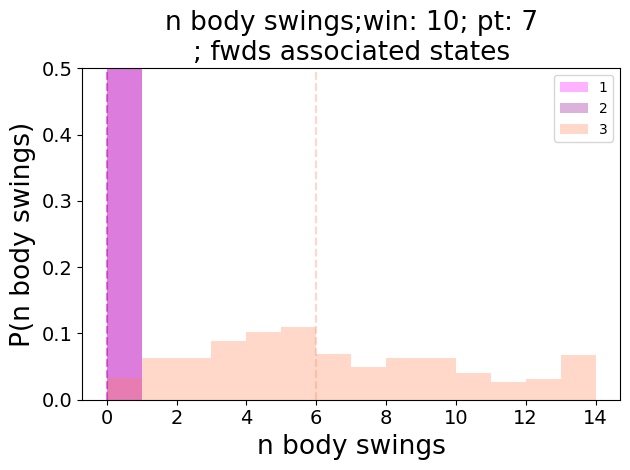

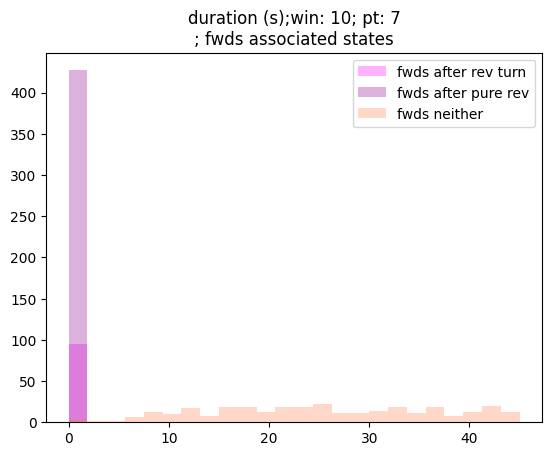

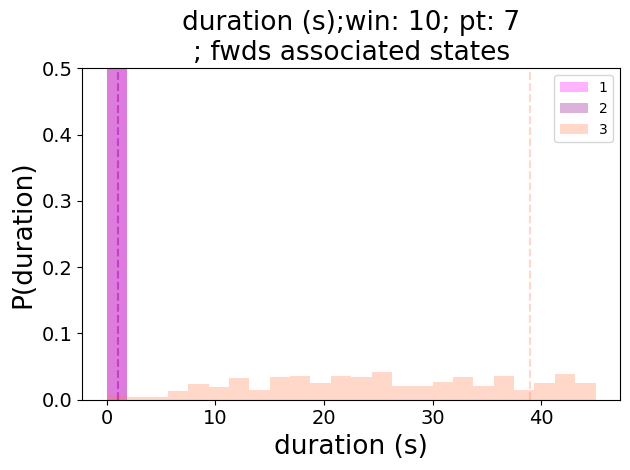

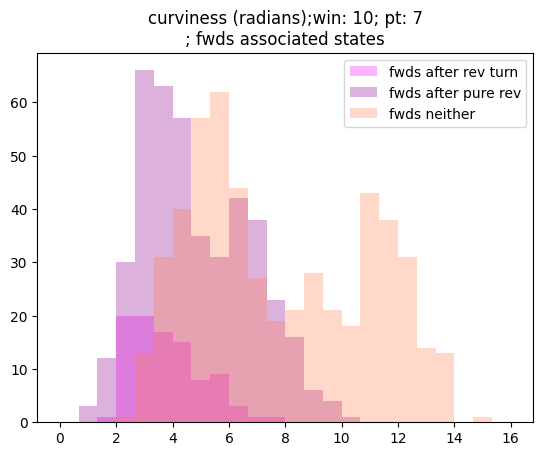

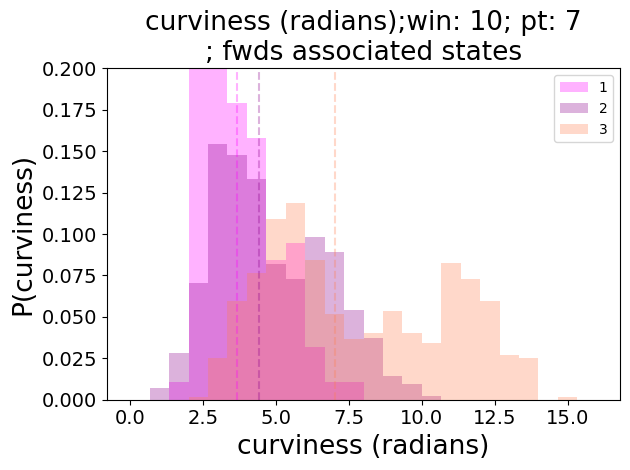

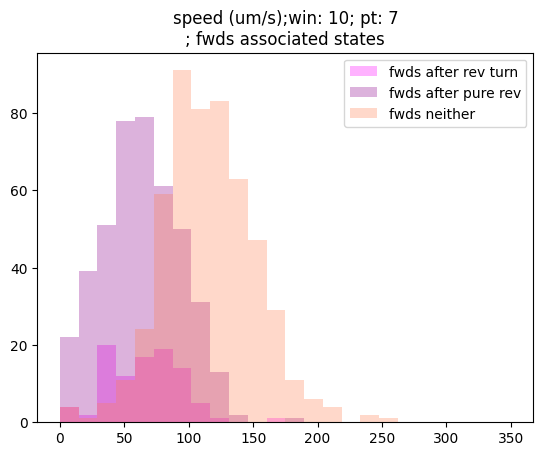

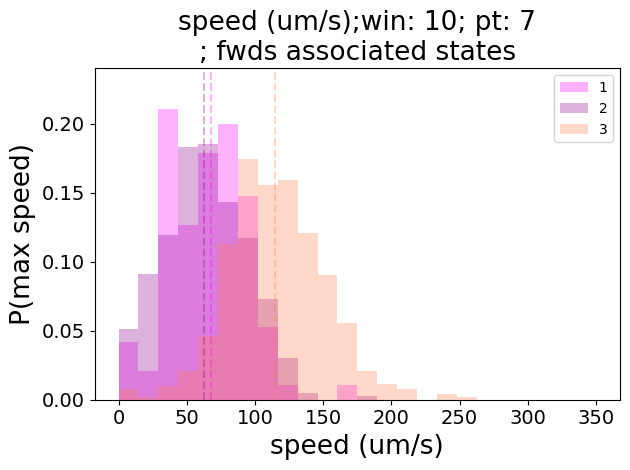

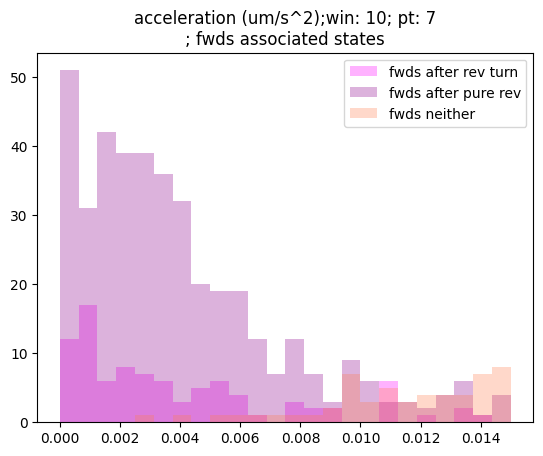

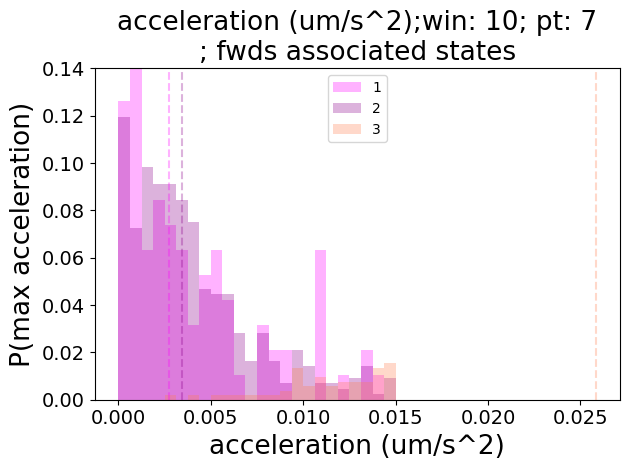

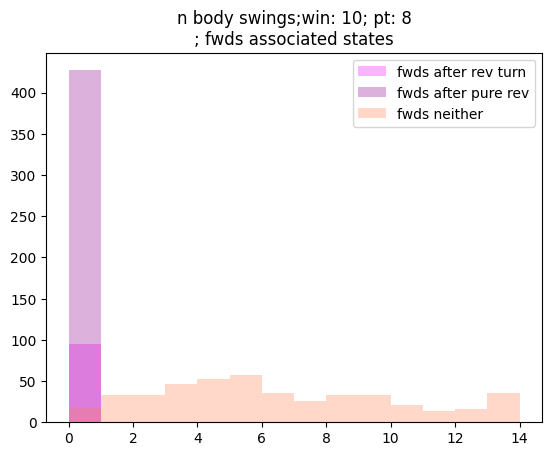

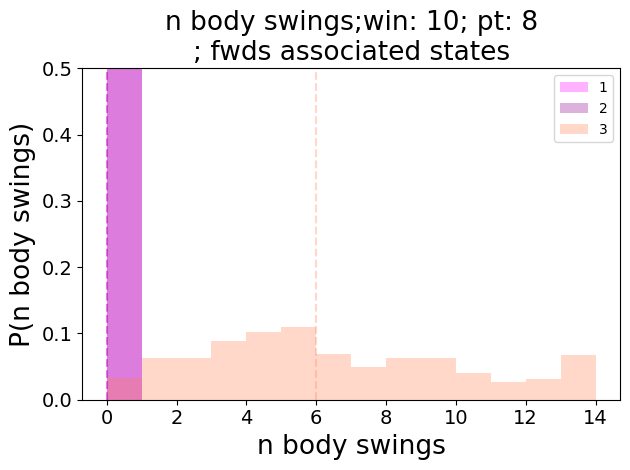

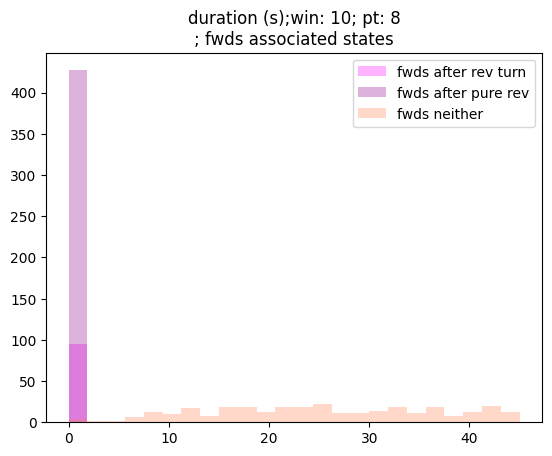

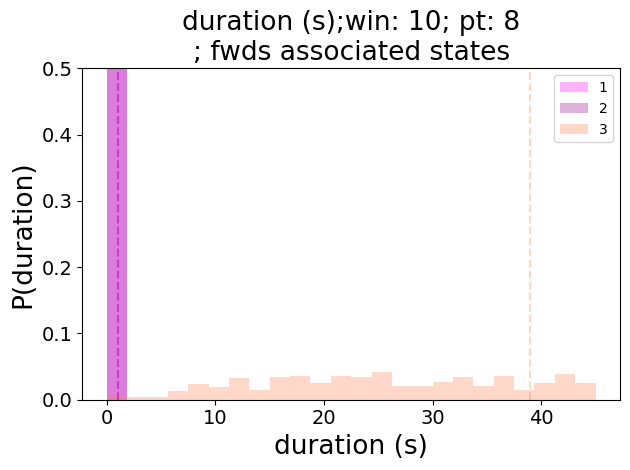

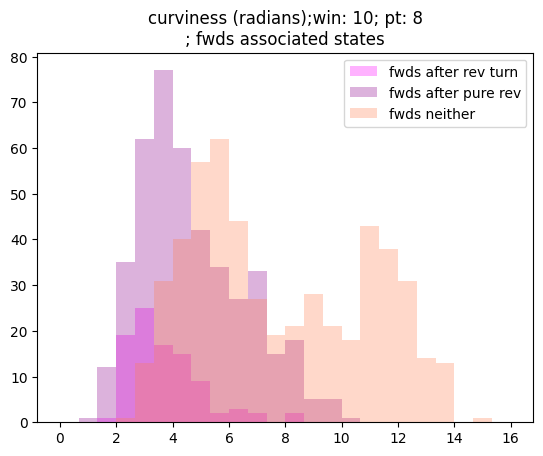

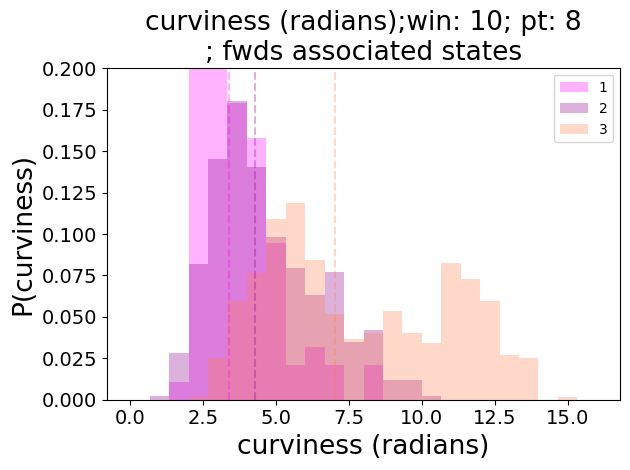

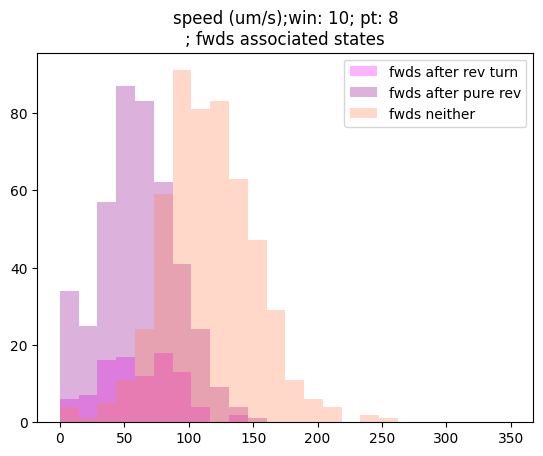

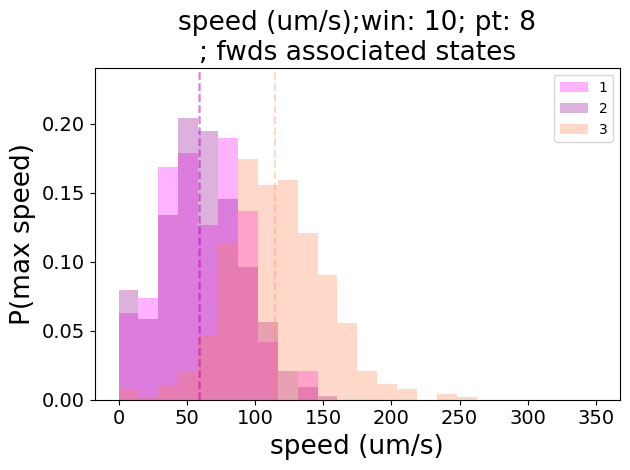

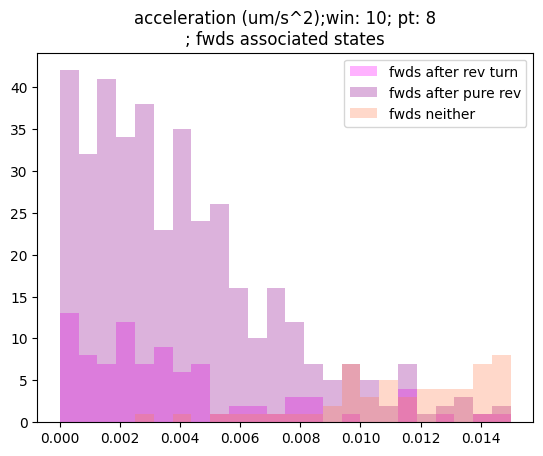

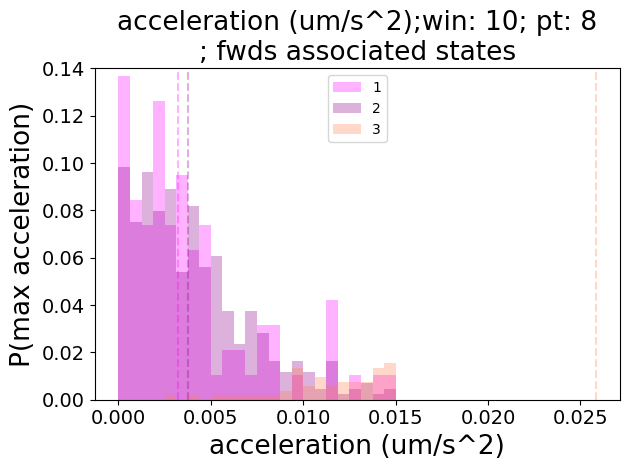

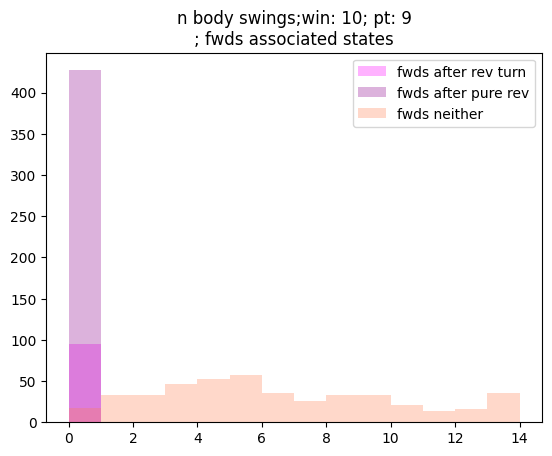

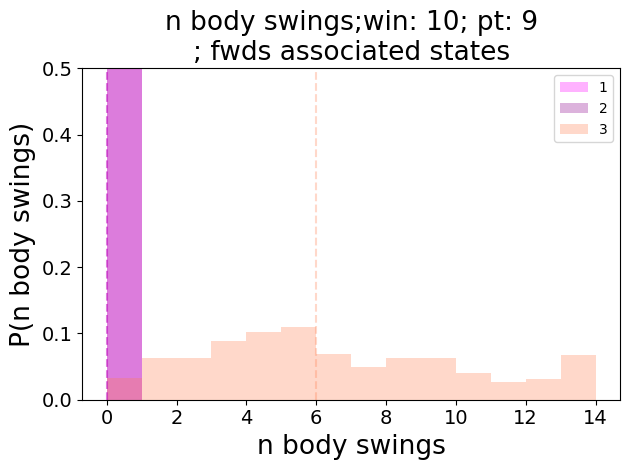

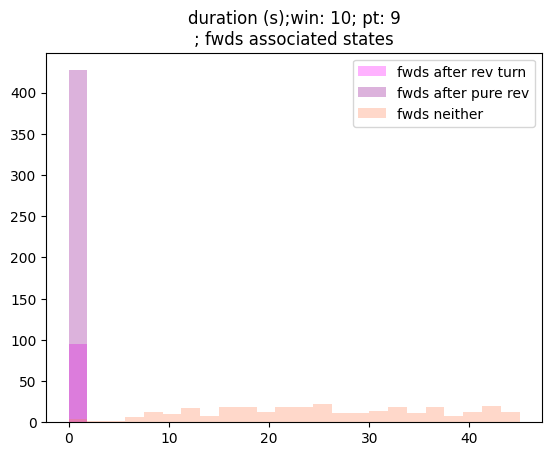

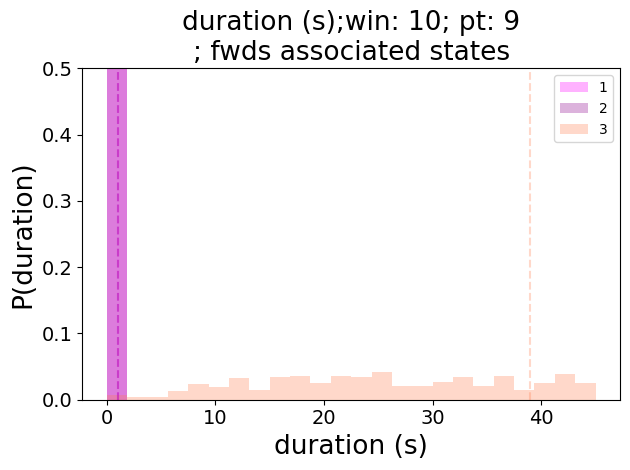

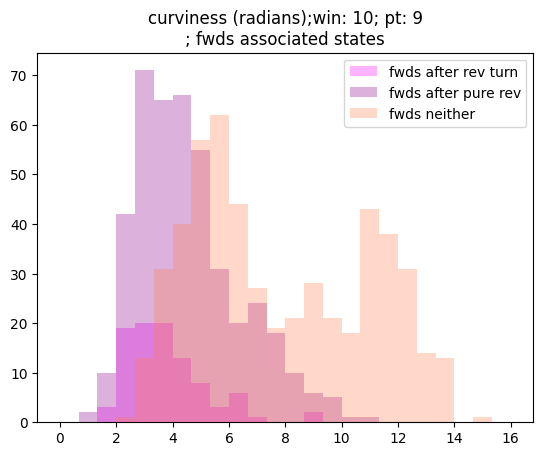

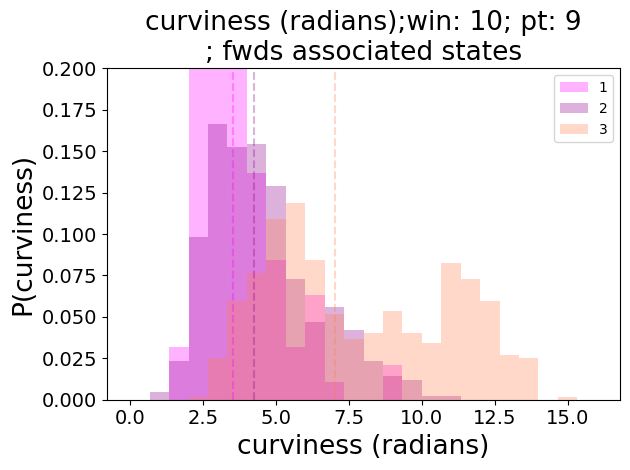

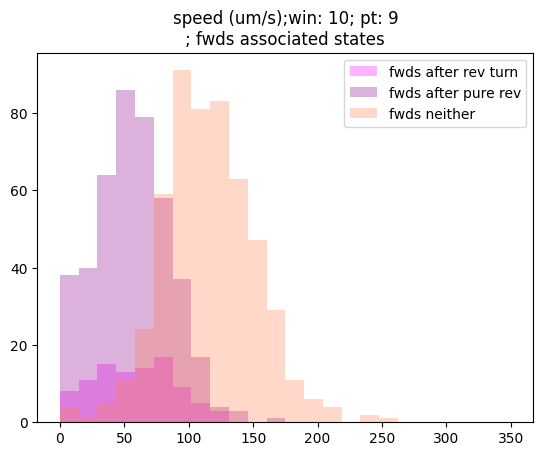

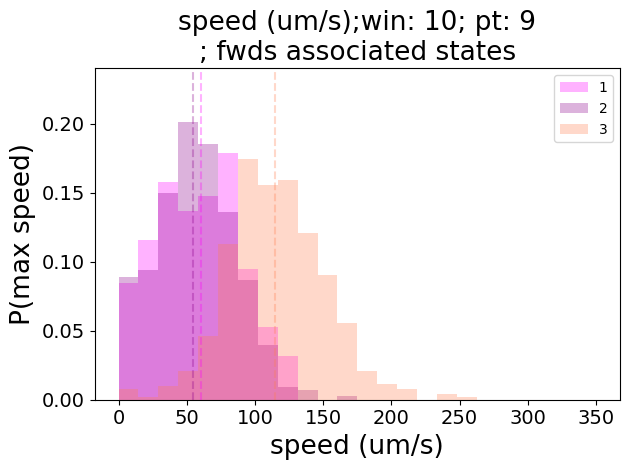

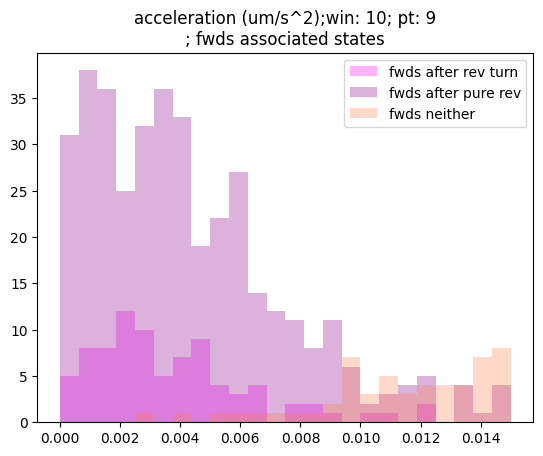

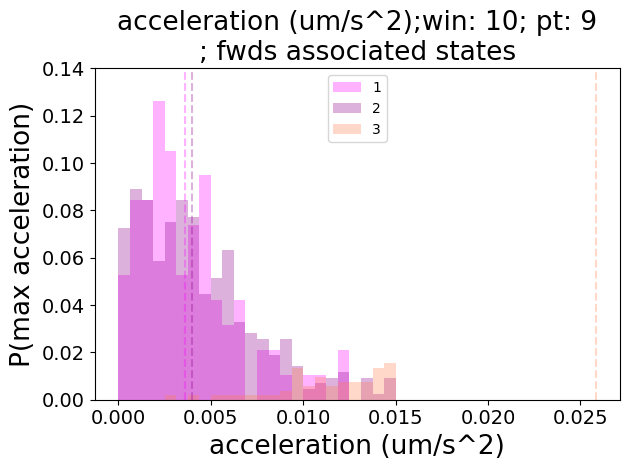

In [34]:
''''
1) get post pure rev vs post rev turn vs fwds
2) get start end is using 
3) get features using__ 
4) get neural acitivty using __ 
5) look at inflection pts speciifically?? (because if just decrease of RIV not interesting
6) look at postivie activity specially? 
'''
from categorize_reor_fncs import get_state_start_ends
from visualize_donut_time_series_and_states import mark_5frame_zero_windows, mark_5frame_zero_windows_return_single_frame

    # fig, axs = plt.subplots(4,5, figsize = (16,7))
    # for i, win in enumerate(range(6,11)):
    #     fwds_after_rev_turn = mark_5frame_zero_windows_return_single_frame(beh_labels, turn_of_rev_turn_bin,win, window=window)
    #     ax = axs[0,i-1]
    #     ax.set_title(f"{win};\n fwd post rev turn")
    #     plot_donut_beh_specific(worm_radii_concat,worm_angles_concat, fwds_after_rev_turn==1, ax, "coral" )
    #     ax.set_xlim(x_lim)
    #     ax.set_ylim(y_lim)
    #     ax.set_aspect('equal')  # ensure circular plots stay circular
        
    #     ax = axs[1,i-1]
    #     ax.hist(worm_angles_concat[fwds_after_rev_turn==1], bins = bins, label = f"full window = {window}", alpha =  0.3)
    #     ax.set_xlim((0, 2*np.pi))
    
    
def get_state_to_track_start_end_is(motor_states_mat):
    states = np.unique(motor_states_mat)
    state_to_track_start_end_is = {}
    for state in states:#[0,1,2]:
        

            
        all_tracks = []
        all_starts = []
        all_ends = []
        for track, state_track in enumerate(motor_states_mat):
        # for track, (state_track, q_z_w) in enumerate(zip( z, q_z)):# (exp_date, behseq) in exp_date_to_beh.items():
            starts, ends = get_state_start_ends(state, state_track,  starts= None, ends = None)
            

            all_tracks.append(np.ones(starts.shape[0])*track)
            all_starts.append(starts)
            all_ends.append(ends)
        state_to_track_start_end_is[state] = np.concatenate([
                                                np.concatenate(all_tracks)[:,None],
                                                np.concatenate(all_starts)[:,None],
                                                np.concatenate(all_ends)[:,None]
                                            ], axis = 1).astype('int')


    return  state_to_track_start_end_is
def get_fwds_after_reor(beh_labels_mat, window = 5 ,timept = None,  full_window = True):
    all_fwds_after_rev_turn = []
    all_fwds_after_pure_rev = []
    all_fwds_neither = []
    for track in beh_labels_mat:
        rev_of_rev_turn_bin, pure_rev_bin, turn_of_rev_turn_bin, pure_turn_bin = make_masks(track)
        
        fwds_after_rev_turn_full_win = mark_5frame_zero_windows(track, turn_of_rev_turn_bin, window=window)
        fwds_after_pure_rev_full_win = mark_5frame_zero_windows(track, pure_rev_bin, window=window)
        
        fwds_neither = np.logical_and(fwds_after_pure_rev_full_win==0, fwds_after_rev_turn_full_win==0)
        
        if full_window: 
            fwds_after_rev_turn = fwds_after_rev_turn_full_win
            fwds_after_pure_rev = fwds_after_pure_rev_full_win
            # fwds_neither = np.logical_and(np.logical_and(fwds_after_pure_rev_full_win==0, fwds_after_rev_turn_full_win==0))
        else: 
            fwds_after_rev_turn = mark_5frame_zero_windows_return_single_frame(track, turn_of_rev_turn_bin, timept, window=window)
            fwds_after_pure_rev = mark_5frame_zero_windows_return_single_frame(track, pure_rev_bin, timept,  window=window)
            

        all_fwds_after_rev_turn.append(fwds_after_rev_turn[:, None])
        all_fwds_after_pure_rev.append(fwds_after_pure_rev[:, None])
        all_fwds_neither.append(fwds_neither[:, None])
        
    return np.concatenate(all_fwds_after_rev_turn, axis = 1).T, np.concatenate(all_fwds_after_pure_rev, axis = 1).T, np.concatenate(all_fwds_neither, axis = 1).T


def plot_feature_hists_motor_states(feature_state_to_feature_vals,feature_to_dict, state_to_color,  state_to_label,
                                    states = None,
                                    features = None, title_supp ="", 
                                    features_to_skip = {}):
    
    # rslds_pairs = [(x,y) for x in rslds_states for y in rslds_states]
    if features is None: 
        features = feature_state_to_feature_vals.keys()
    if states is None:
        states = state_to_feature_vals[features[0]].keys()
        
    for feature in features: 
        if feature in features_to_skip:
            continue
        state_to_feature_vals  = feature_state_to_feature_vals[feature]
        fig1, ax1 = plt.subplots()
        for state in states:#[0,1,2]:

            feature_vals = state_to_feature_vals[state]

            ax1.hist(np.array(feature_vals),
                                    # bins= feature_to_dict[feature]["bins"], 
                                    bins = feature_to_dict[feature]["bins"], # np.arange(0, 15, 1)
                                    color = state_to_color[state], label = state_to_label[state], 
                                    alpha = 0.3)
        title = f"{feature};{title_supp}; fwds associated states"
        ax1.set_title(title)
        ax1.legend()

    
        state_to_feature = {state: remove_nans( state_to_feature_vals[state]) 
                                                    for  state in states
                                  }
        fig1, ax1 = plt.subplots()
        if np.all(np.array([feature_val.size >0 for feature_val in state_to_feature.values()])):
            plot_hist_across_conditins_and_get_KS_stats(state_to_feature,  state_to_color,
                                                    title = title, 
                                                    ylabel = feature_to_dict[feature]["ylabel"],
                                                    xlabel = f"{feature}",
                                                    stat_color = "tomato" ,
                                                    bins = feature_to_dict[feature]["bins"], # np.arange(0, 15, 1)
                                                    ylim = feature_to_dict[feature]["ylim"], 
                                                    alpha = 0.3, 
                                                    fill =  True,
                                                    fig = fig1, 
                                                    ax = ax1 , 
                                                    print_sig = False,
                                                    print_effect_size = False, 
                                                    legend = False,
                                                    plot_medians = True
                                                    )
        ax1.legend()

all_fwds_states_to_label = {
    1: "fwds after rev turn",
    2: "fwds after pure rev", 
    3: "fwds neither"
}

state_to_color = {
    1: "magenta",
    2: "darkmagenta" , 
    3: "coral"
}


window = 10

all_fwds_after_rev_turn , all_fwds_after_pure_rev, all_fwds_neither = get_fwds_after_reor(z, window = 10, full_window = True )
all_fwds_states_mat = np.zeros(all_fwds_after_rev_turn.shape)
all_fwds_states_mat[all_fwds_after_rev_turn.astype('bool')] = 1
all_fwds_states_mat[all_fwds_after_pure_rev.astype('bool')] = 2
all_fwds_states_mat[all_fwds_neither.astype('bool')] = 3

state_to_track_start_end_is = get_state_to_track_start_end_is(all_fwds_states_mat)
feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is)

plot_feature_hists_motor_states(feature_state_to_feature_vals, 
                                    feature_to_dict,
                                    state_to_color, 
                                    all_fwds_states_to_label,
                                    states = [1,2,3],
                                    features = None, 
                    
                                )


for timept in range(0,window):
    
    all_fwds_after_rev_turn , all_fwds_after_pure_rev, all_fwds_neither = get_fwds_after_reor(z, timept = timept, window = window, full_window = False )
    all_fwds_states_mat = np.zeros(all_fwds_after_rev_turn.shape)
    all_fwds_states_mat[all_fwds_after_rev_turn.astype('bool')] = 1
    all_fwds_states_mat[all_fwds_after_pure_rev.astype('bool')] = 2
    all_fwds_states_mat[all_fwds_neither.astype('bool')] = 3

    state_to_track_start_end_is = get_state_to_track_start_end_is(all_fwds_states_mat)
    feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is)
    features = list(feature_state_to_feature_vals.keys())
    plot_feature_hists_motor_states(feature_state_to_feature_vals, 
                                    feature_to_dict,
                                    state_to_color, 
                                    all_fwds_states_to_label,
                                    states = [1,2,3],
                                    features = None, 
                                    title_supp = f"win: {window}; pt: {timept}\n"
                                    
                                )
    

[[   0  615]
 [   0  616]
 [   0  617]
 ...
 [  20 1268]
 [  20 1269]
 [  20 1270]]
[[   0  615]
 [   0  616]
 [   0  617]
 ...
 [  20 1268]
 [  20 1269]
 [  20 1270]]


feature n body swings
feature duration (s)
feature curviness (radians)
feature speed (um/s)
feature acceleration (um/s^2)
feature neural_activity_mean


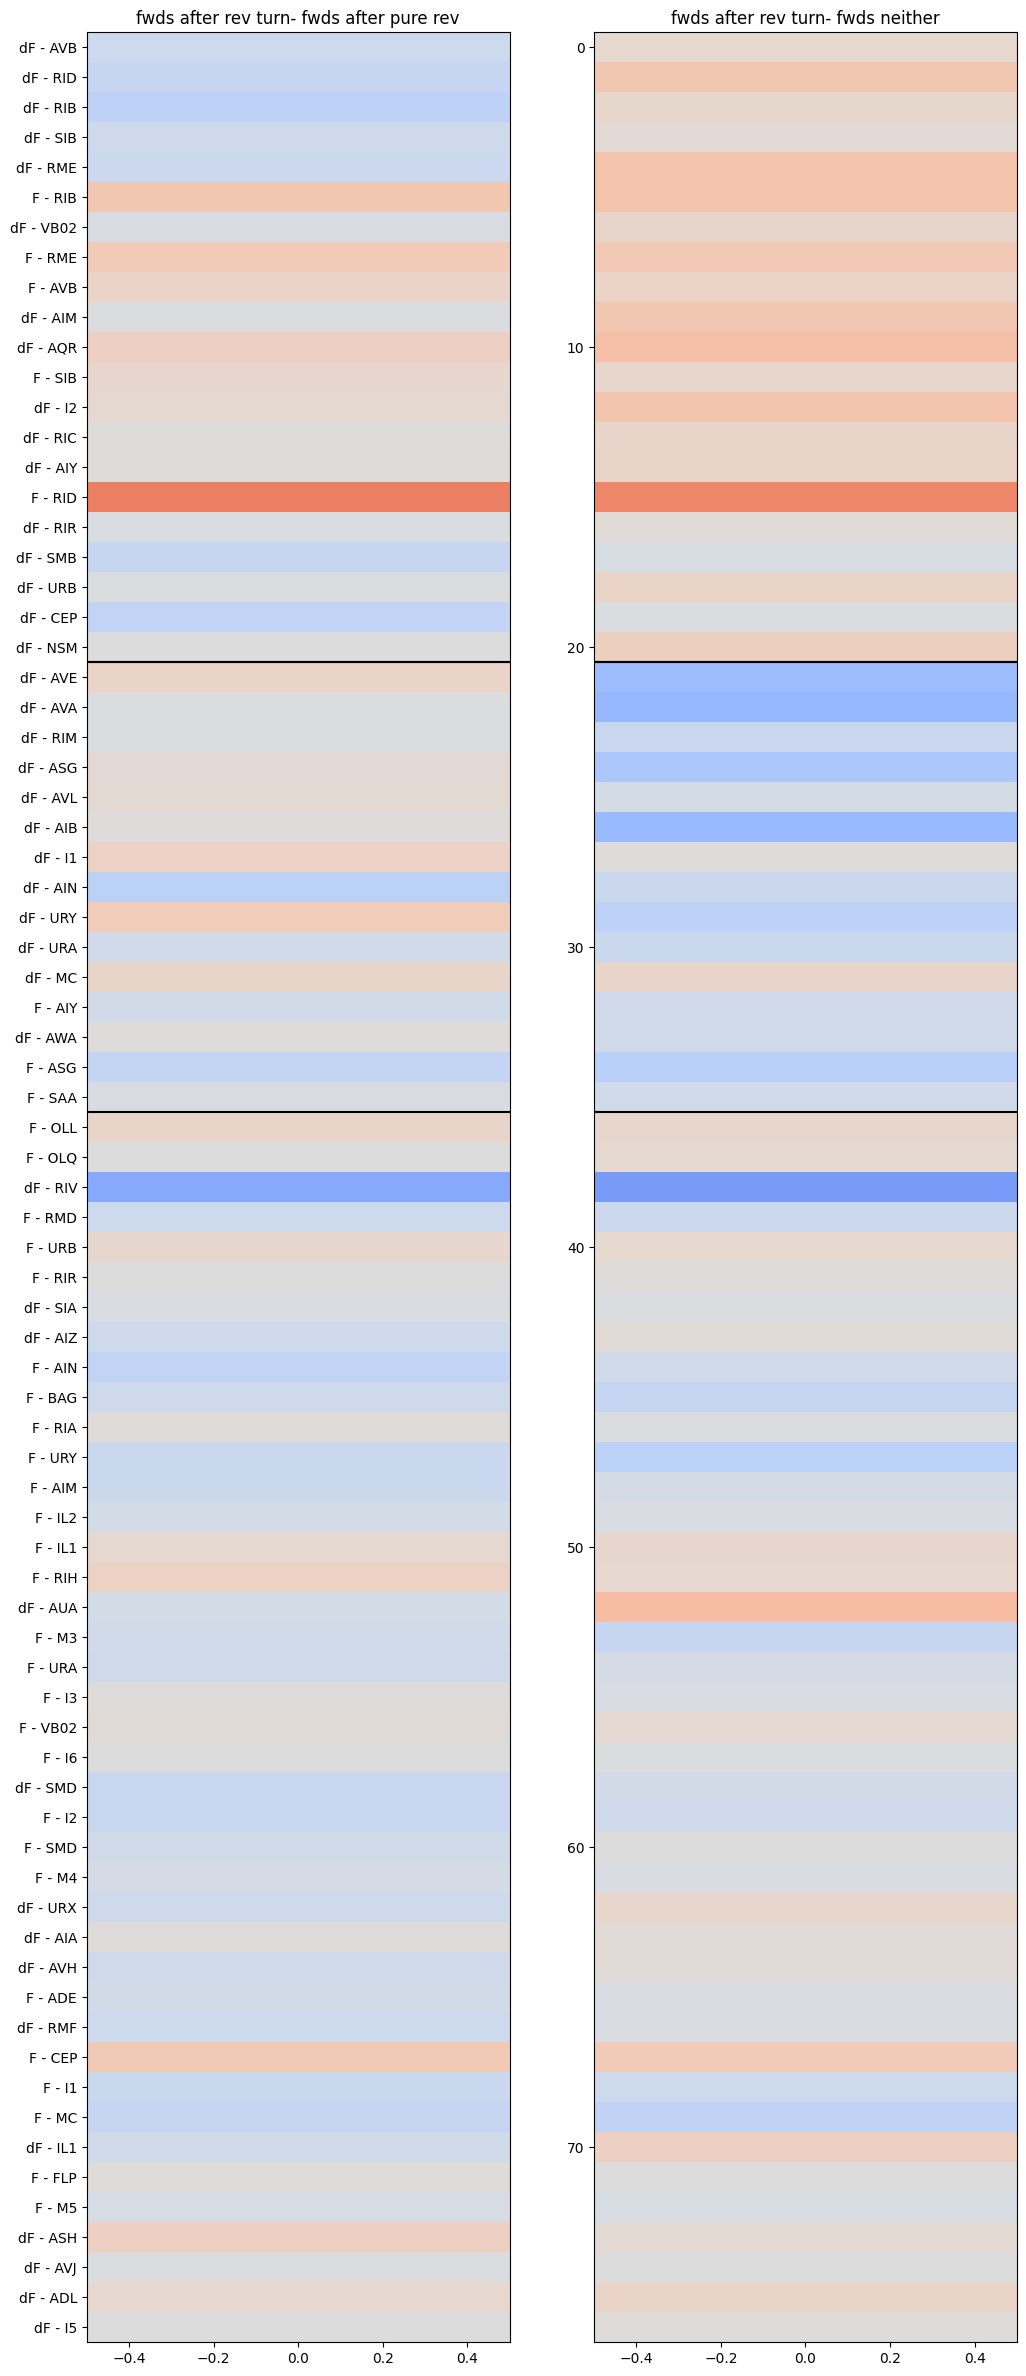

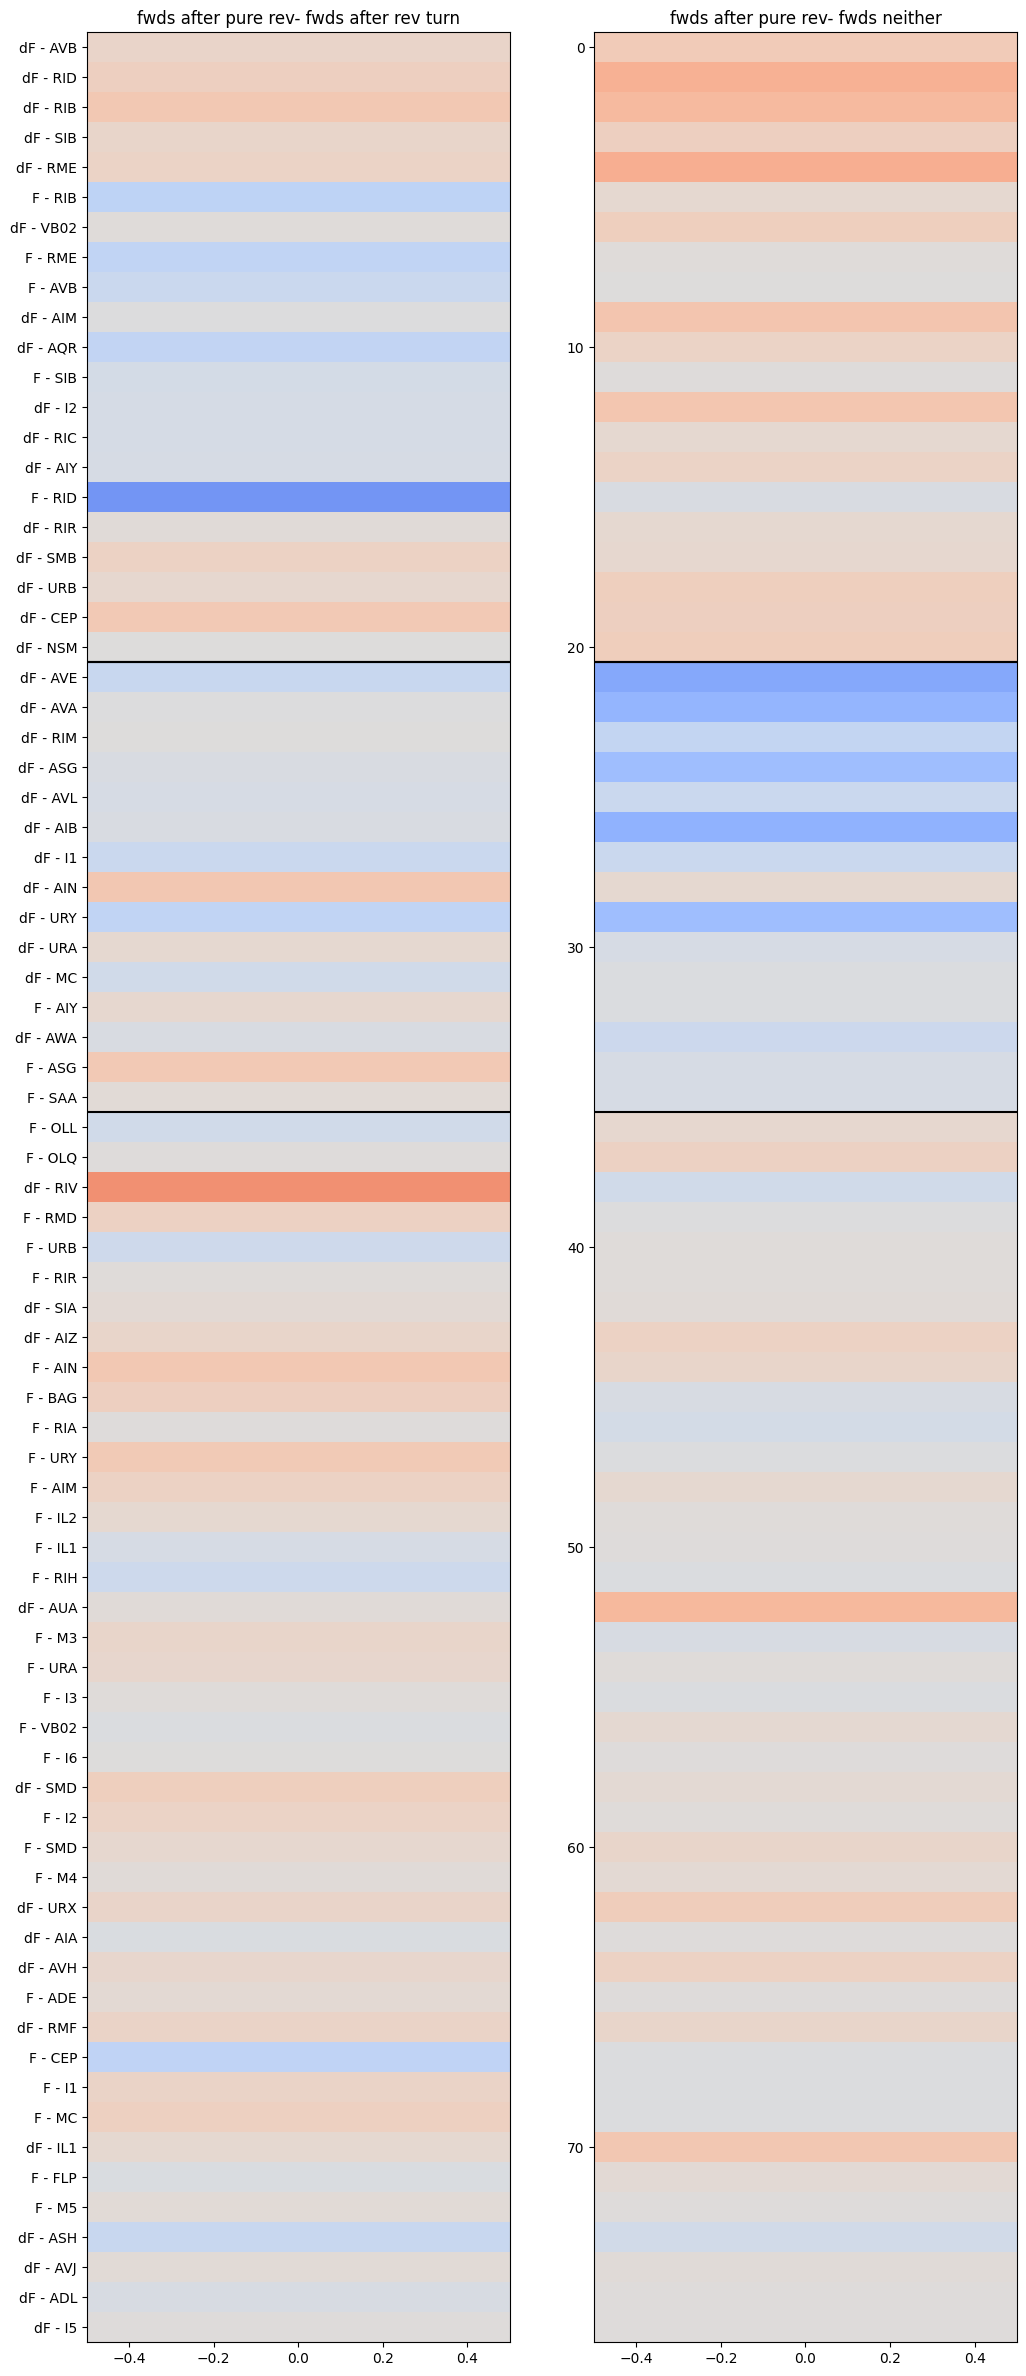

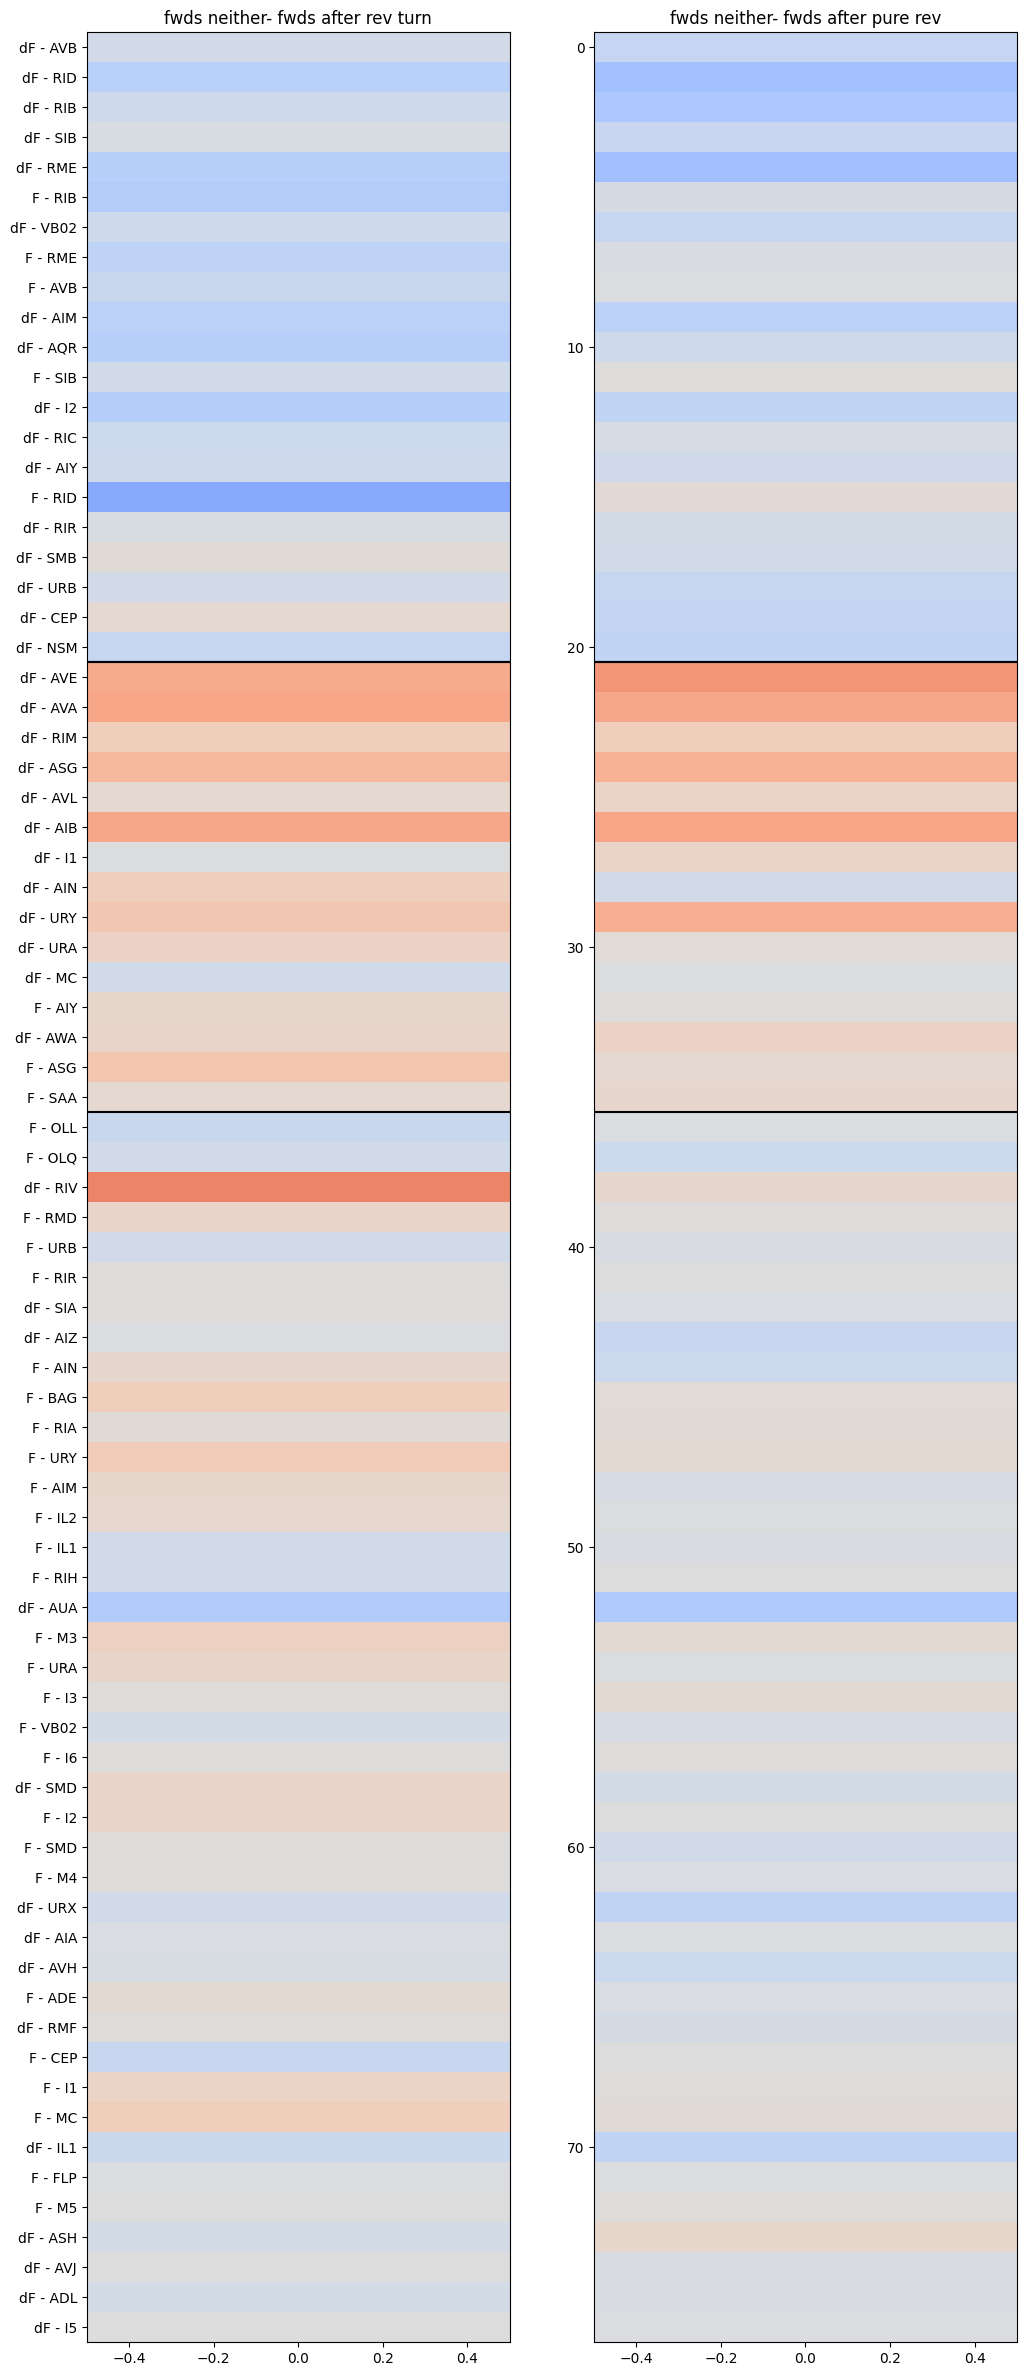

In [ ]:
''' plot neural activity'''

neural_feature_to_dict = {
    "neural_activity_mean":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmean(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
            "neural_activity_min":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmin(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
                    "neural_activity_max":
        {
        # "exp_date_to_feature":  {date: get_body_angle_mag_from_midline(midline)[1][:, 20] for date,midline in exp_date_to_midlines.items() },
        # "bins": np.arange(0, 15, 1), 
         "feature_fnc": lambda neuralseq: np.nanmax(neuralseq, axis = 0), 
         "ylim": [0, 0.5],
          "ylabel": "mean", 
              "feature_mat": np.array(Y)
    },
        
    
}

def plot_neural_activity_state_bin(neural_feature_to_dict,state_to_track_start_end_is, state_to_label, neural_labels, neural_labels_cropped):
    # pairs = list(pair_to_vals_dict.keys())
    state_to_neural_activity_means = get_features_from_track_start_end_is(neural_feature_to_dict, state_to_track_start_end_is, features = ["neural_activity_mean"] )["neural_activity_mean"]
    states = state_to_track_start_end_is.keys()
    
    for state1 in states:
        state_specific_mean_diffs = []
        col_titles = []

        for state2 in states:
            if state1 == state2: 
                continue
            state1_vals = np.array(state_to_neural_activity_means[state1])
            state2_vals = np.array(state_to_neural_activity_means[state2])

            
            


                
            n_state1_instances = len(state1_vals)
            n_state2_instances = len(state2_vals)
            if n_state1_instances<15:
                print("skipping, ", state1, n_state1_instances)
                continue
            if n_state2_instances<15:
                print("skipping, ", state2, n_state2_instances)
                continue
            diffs  = get_pair_wise_avgs(state1_vals, state2_vals, max_comparisons = 1000, random_state=None)
            mean_diffs = np.nanmean(diffs, axis = 0 )[:, None]

            state_specific_mean_diffs.append(mean_diffs)
            col_titles.append(f"{state_to_label[state1]}- {state_to_label[state2]}")
        state_specific_mean_diffs = np.concatenate(state_specific_mean_diffs, axis = 1)
        plot_neural_activity_heatmap(state_specific_mean_diffs, neural_labels, col_titles, neural_labels_to_plot = neural_labels_cropped, border_neurons = ['dF - AVE'
    , "dF - AVE", "F - OLL"])


import os
contributor_thres = 0.05
foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
with open(os.path.join(foldername, f'high_contributing_neurons_rslds_{contributor_thres}.txt')) as f:
    neural_labels_cropped = [line.strip() for line in f]






window = 10

all_fwds_after_rev_turn , all_fwds_after_pure_rev, all_fwds_neither = get_fwds_after_reor(z, window = 10, full_window = True )
all_fwds_states_mat = np.zeros(all_fwds_after_rev_turn.shape)
all_fwds_states_mat[all_fwds_after_rev_turn.astype('bool')] = 1
all_fwds_states_mat[all_fwds_after_pure_rev.astype('bool')] = 2
all_fwds_states_mat[all_fwds_neither.astype('bool')] = 3

state_to_track_start_end_is = get_state_to_track_start_end_is(all_fwds_states_mat)
feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is)

plot_neural_activity_state_bin(neural_feature_to_dict,state_to_track_start_end_is, all_fwds_states_to_label, neural_labels, neural_labels_cropped)

    
    

/Users/friederikebuck/Downloads/worm notes/worm_code/spont_rev_prediction_fncs.py:629: RuntimeWarning: Mean of empty slice
  average_row = np.nanmean(sampled_data, axis=0)


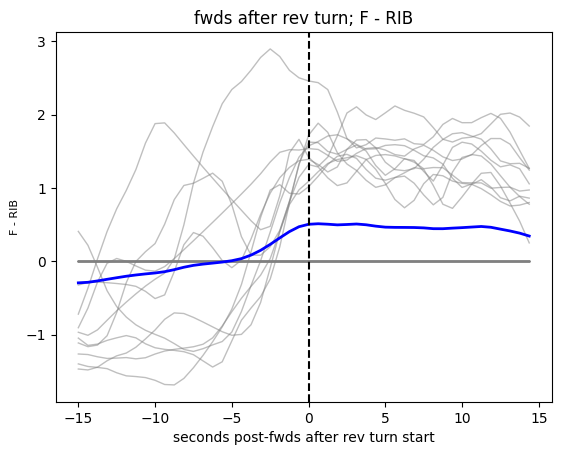

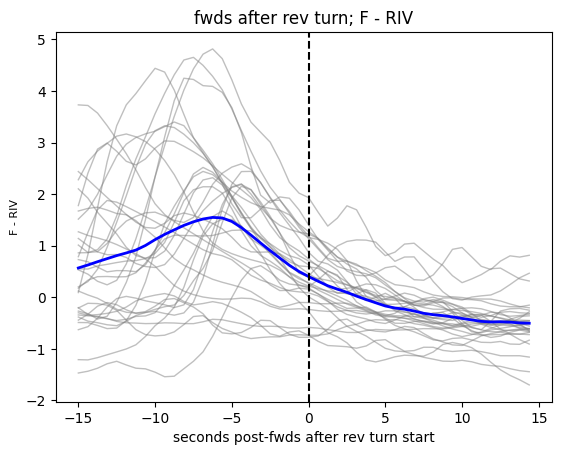

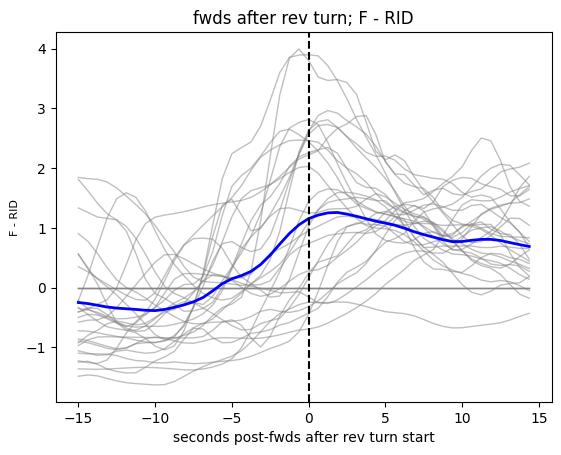

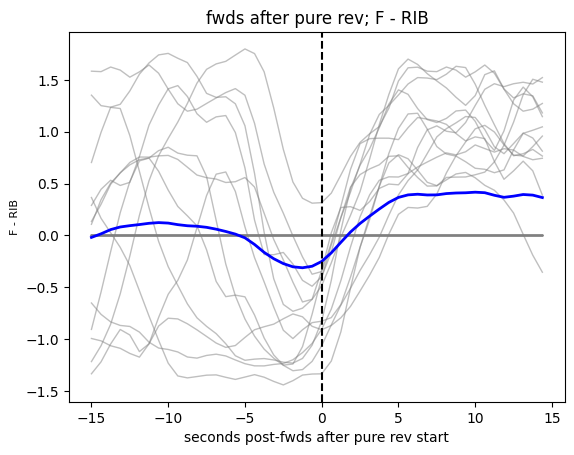

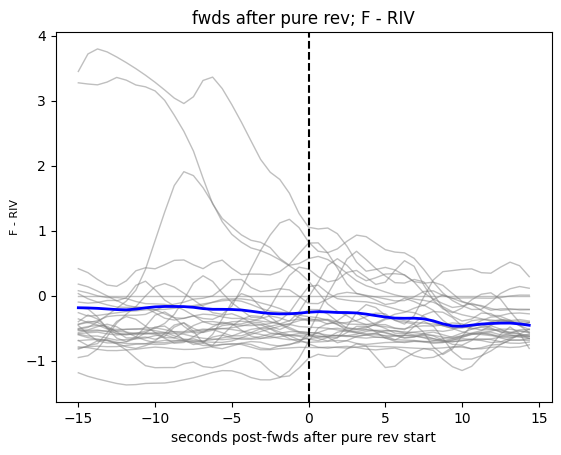

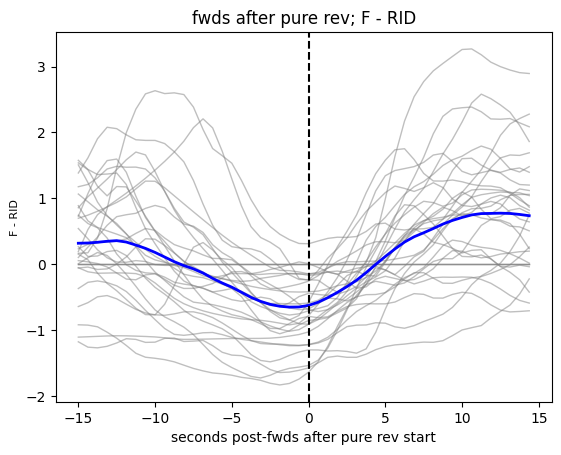

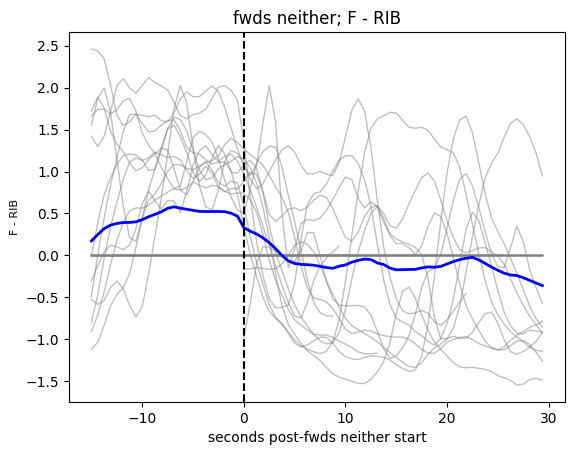

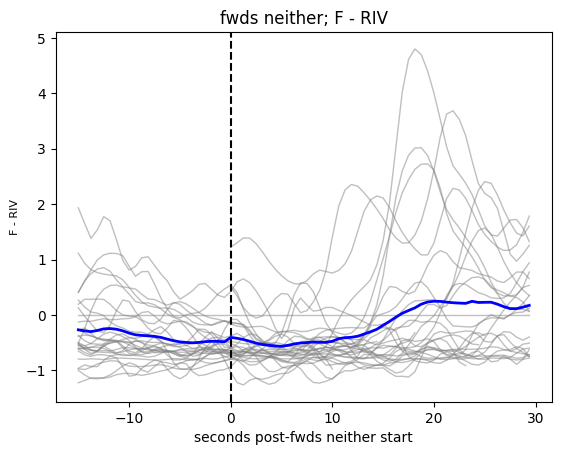

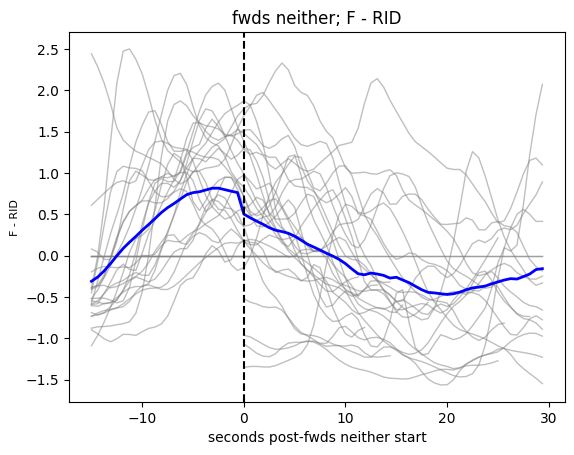

In [ ]:
'''plot state start aligned neural activty'''


'''align RID, RIB, RIV '''
from spont_rev_prediction_fncs import plot_mean_line_graph_with_individ_traces#, align_rev_to_stim_start_from_start_end_is, filter_start_end_is_by_start_time


def align_feature_to_rev_start_from_start_end_is(feature_val, event_start_end_is,  n_pre_frames = 60, max_plotting_length_frames = 500, 
                               rev_duration_min_frames = -1, rev_duration_max_frames = np.inf 
                            #    earliest_start_frame = None, earliest_end_frame = None
                               
                               ):
    
    buffered_event_features = []
    durations = event_start_end_is[:,2]-event_start_end_is[:,1]
    dur_bool = np.logical_and(durations>rev_duration_min_frames, durations<=rev_duration_max_frames).astype('bool')
    event_start_end_is_duration = event_start_end_is[dur_bool]
    for track, rev_start_i, rev_end_i in event_start_end_is_duration:
        
            frame_start = max(rev_start_i-n_pre_frames, 0)
            frame_end = min(rev_start_i+max_plotting_length_frames, rev_end_i)
        
            n_rev_frames = frame_end-rev_start_i
            n_fwd_frames = rev_start_i-frame_start
            buffered_event_feature = np.zeros(n_pre_frames+max_plotting_length_frames)
            buffered_event_feature[:] = np.nan
            buffered_event_feature[int(n_pre_frames+-1*n_fwd_frames):int(n_pre_frames+n_rev_frames)] = feature_val[track, frame_start:frame_end]
            buffered_event_features.append(buffered_event_feature[:, None])

    if len(buffered_event_features)==0: 
        return np.array([])

    # buffered_event_features = np.concatenate(buffered_event_features, axis = 0)
    buffered_event_features = np.concatenate(buffered_event_features, axis = 1)
    return buffered_event_features





def align_neural_activity_list_to_state_start(neuron_labels, neural_labels_all, Y, event_start_end_is,state_lbl,
                                              n_pre_frames = 60,
                                              max_plotting_length_frames = 500, 
                                              fps = 1.6):
    for neuron_label in neuron_labels:
        neuron_i = np.where(neural_labels_all == neuron_label)[0][0]
        neuron_activity = Y[:, :, neuron_i]
        
        aligned_neuron_activity = align_feature_to_rev_start_from_start_end_is(neuron_activity, event_start_end_is,  n_pre_frames = n_pre_frames,
                                                                               max_plotting_length_frames = max_plotting_length_frames, 
                                    # rev_duration_min_frames = None, rev_duration_max_frames = None ,
                                    #    earliest_start_frame = None, earliest_end_frame = None
                                    
                                    )
        
        fig, ax = plt.subplots()
        plot_mean_line_graph_with_individ_traces(aligned_neuron_activity.T, n_pre_frames, fps = fps,  fig = fig, ax =ax, seconds = None, 
                                            title = f"{state_lbl}; {neuron_label}", 
                                                xlabel =f"seconds post-{state_lbl} start", 
                                                ylabel =f"{neuron_label}", color = "blue", ylim =None,  ylabel_font_size = 8, 
                                                max_n_tracks = 30,line_width=1.0
                                        
                                                )
        

contributor_thres = 0.05
foldername = "/Users/friederikebuck/Downloads/worm notes/processed_checkpts/test_rslds_QM_run_061325/model_selection/top_2_combined/"
with open(os.path.join(foldername, f'high_contributing_neurons_rslds_{contributor_thres}.txt')) as f:
    neural_labels_cropped = [line.strip() for line in f]

window = int(1.6*15)
all_fwds_after_rev_turn , all_fwds_after_pure_rev, all_fwds_neither = get_fwds_after_reor(z, window = window, full_window = True )
all_fwds_states_mat = np.zeros(all_fwds_after_rev_turn.shape)
all_fwds_states_mat[all_fwds_after_rev_turn.astype('bool')] = 1
all_fwds_states_mat[all_fwds_after_pure_rev.astype('bool')] = 2
all_fwds_states_mat[all_fwds_neither.astype('bool')] = 3

state_to_track_start_end_is = get_state_to_track_start_end_is(all_fwds_states_mat)
# feature_state_to_feature_vals = get_features_from_track_start_end_is(feature_to_dict, state_to_track_start_end_is)

# plot_neural_activity_state_bin(neural_feature_to_dict,state_to_track_start_end_is, all_fwds_states_to_label, neural_labels, neural_labels_cropped)

Y = np.array(Y)
fps = 1.6
states = list(state_to_track_start_end_is.keys())
for state in states: 
    state_lbl = all_fwds_states_to_label[state]
    align_neural_activity_list_to_state_start(["F - RIB", "F - RIV", "F - RID"], neural_labels, Y, state_to_track_start_end_is[state],
                                                state_lbl,
                                                n_pre_frames = int(fps*15),
                                                max_plotting_length_frames = int(fps*30), 
                                                fps = fps)
##RIB and RID already increasing during turn (ie at rev termination)= RIB for fsure; RIB less clear..? 
##what makes it a revresal vs a turn?  